In [163]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import find_peaks
from typing import Union

## Funciones Globales

In [164]:
# Constants
emotion_translation = {
    "neutral": "neutral",
    "anger": "enojo",
    "surprise": "sorpresa",
    "fear": "miedo",
    "joy": "alegría",
    "sadness": "tristeza",
    "disgust": "repulsión",
    "love": "amor",
    "unknown": "desconocido"
}

emotion_colors = {
    "neutral": "#A9A9A9",      # gris
    "enojo": "#D62728",        # rojo fuerte
    "sorpresa": "#FF7F0E",     # naranja
    "miedo": "#9467BD",        # púrpura
    "alegría": "#2CA02C",      # verde
    "tristeza": "#1F77B4",     # azul
    "repulsión": "#8C564B",    # marrón
    "amor": "#E377C2",         # rosa
    "desconocido": "#7F7F7F"   # gris oscuro
}

In [185]:
def get_emotions_count(df: pd.DataFrame, emotion_column: str = "predicted_emotion") -> Union[pd.DataFrame, None]:
    """
    Computes the count of each emotion in the specified column of a DataFrame.

    Parameters:
        df (pd.DataFrame): The input DataFrame containing the emotion data.
        emotion_column (str): The name of the column containing emotion labels. Default is "emotion".

    Returns:
        pd.DataFrame: A DataFrame with emotions and their counts, sorted by count in descending order.
        None: If the input DataFrame is empty or the specified column is missing.
    """
    if emotion_column not in df.columns:
        print(f"Error: Column '{emotion_column}' not found in the DataFrame.")
        return None

    if df.empty:
        print("Error: The input DataFrame is empty.")
        return None

    # Normalize and count emotions
    emotion_counts = df[emotion_column].str.lower().str.strip().value_counts()

    # Create a DataFrame from the counts
    emotions_df = emotion_counts.reset_index()
    emotions_df.columns = ["Emoción", "Cantidad"]

    # Sort the DataFrame by count in descending order
    emotions_df = emotions_df.sort_values(by="Cantidad", ascending=False).reset_index(drop=True)

    return emotions_df

def translate_emotions(df: pd.DataFrame, emotion_column: str = "predicted_emotion") -> pd.DataFrame:
    """
    Translates emotions in the specified column of a DataFrame to Spanish.

    Parameters:
        df (pd.DataFrame): The input DataFrame containing the emotion data.
        emotion_column (str): The name of the column containing emotion labels. Default is "predicted_emotion".

    Returns:
        pd.DataFrame: A DataFrame with the translated emotions.
    """
    if emotion_column not in df.columns:
        print(f"Error: Column '{emotion_column}' not found in the DataFrame.")
        return df

    # Translate emotions using the mapping
    df[emotion_column] = df[emotion_column].str.lower().map(emotion_translation).fillna(df[emotion_column])

    return df

def plot_emotions_count(df: pd.DataFrame, title: str = "Conteo de emociones") -> None:
    """
    Plots the count of emotions from a DataFrame and displays values on the bars.

    Parameters:
        df (pd.DataFrame): The DataFrame containing emotion counts with 'Emoción' and 'Cantidad' columns.
        title (str): The title of the plot. Default is "Conteo de emociones".
    """
    colors = [emotion_colors.get(emocion, "gray") for emocion in df["Emoción"]]

    plt.figure(figsize=(10, 6))
    bars = plt.barh(df["Emoción"], df["Cantidad"], color=colors, alpha=0.5)
    plt.xlabel("Cantidad")
    plt.title(title)
    plt.gca().invert_yaxis()

    # Añadir los valores sobre cada barra
    for bar in bars:
        width = bar.get_width()
        plt.text(width + 10000, bar.get_y() + bar.get_height()/2,
                 f'{int(width):,}', va='center')

    # Quitar bordes superior y derecho
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.tight_layout()
    plt.show()

In [186]:
def process_emotion_counts_by_period(
    df: pd.DataFrame,
    period: str = "D",  # "D"=diario, "W"=semanal, "M"=mensual
    time_column: str = "created_time",
    emotion_column: str = "predicted_emotion"
) -> pd.DataFrame:
    """
    Agrupa los conteos de emociones por un periodo determinado.

    Parameters:
        df (pd.DataFrame): DataFrame de entrada.
        period (str): "D" (día), "W" (semana), o "M" (mes).
        time_column (str): Nombre de la columna de fecha.
        emotion_column (str): Nombre de la columna de emociones.

    Returns:
        pd.DataFrame: DataFrame con conteos por periodo.
    """
    df[time_column] = pd.to_datetime(df[time_column])
    df["period"] = df[time_column].dt.to_period(period).apply(lambda r: r.start_time)
    emotion_counts = df.groupby(["period", emotion_column]).size().unstack(fill_value=0)
    return emotion_counts.sort_index()

def plot_emotion_counts_by_period(
    emotion_counts: pd.DataFrame,
    title: str = "Evolución de sentimientos",
    ylabel: str = "Cantidad"
) -> None:
    """
    Grafica los conteos de emociones por periodo.
    """
    plt.figure(figsize=(14, 6))
    available_emotions = [e for e in emotion_colors if e in emotion_counts.columns]
    colors = [emotion_colors[e] for e in available_emotions]

    emotion_counts[available_emotions].plot(kind="line", color=colors, figsize=(15, 6))

    plt.title(title)
    plt.xlabel("Periodo")
    plt.ylabel(ylabel)
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend(title="Sentimiento")
    plt.tight_layout()
    plt.show()

def plot_emotion_proportions_by_period(
    emotion_counts: pd.DataFrame,
    title: str = "Proporción de emociones por periodo"
) -> None:
    """
    Grafica las proporciones de emociones por periodo.
    """
    proportions = emotion_counts.div(emotion_counts.sum(axis=1), axis=0)

    plt.figure(figsize=(14, 6))
    available_emotions = [e for e in emotion_colors if e in proportions.columns]
    colors = [emotion_colors[e] for e in available_emotions]

    proportions[available_emotions].plot(kind="line", color=colors, figsize=(15, 6))

    plt.title(title)
    plt.xlabel("Periodo")
    plt.ylabel("Proporción")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend(title="Sentimiento")
    plt.tight_layout()
    plt.show()

In [198]:
def get_dominant_emotion_per_period(emotion_counts: pd.DataFrame) -> pd.Series:
    """
    Devuelve la emoción predominante por periodo.
    """
    return emotion_counts.idxmax(axis=1)



def plot_dominant_emotion(
    emotion_counts: pd.DataFrame,
    title: str = "Emoción dominante por periodo",
    x_label: str = "Periodo",
    period_type: str = "semana",
    exclude_emotions: list = None
) -> pd.DataFrame:
    """
    Grafica la emoción dominante para cada periodo.

    Parameters:
        emotion_counts (pd.DataFrame): DataFrame con conteos de emociones por periodo
        title (str): Título del gráfico
        x_label (str): Etiqueta del eje X
        period_type (str): Tipo de periodo ("día", "semana", "mes") para el título
        exclude_emotions (list): Lista de emociones a excluir del análisis (por ejemplo, ["neutral"])

    Returns:
        pd.DataFrame: DataFrame con las emociones dominantes por periodo
    """
    # Hacer una copia para evitar modificar el original
    emotion_counts_filtered = emotion_counts.copy()

    # Excluir emociones si se especifican
    if exclude_emotions:
        for emotion in exclude_emotions:
            if emotion in emotion_counts_filtered.columns:
                emotion_counts_filtered = emotion_counts_filtered.drop(columns=[emotion])

    # Obtener emoción dominante por periodo
    dominant_emotions = get_dominant_emotion_per_period(emotion_counts_filtered)

    # Convertir a DataFrame
    df_dominant = dominant_emotions.reset_index()
    df_dominant.columns = ["period", "emotion"]

    # Graficar puntos categóricos
    plt.figure(figsize=(14, 5))
    sns.scatterplot(data=df_dominant, x="period", y="emotion",
                   hue="emotion", palette=emotion_colors, s=100)

    # Si no se especifica un título personalizado, usar uno genérico con el tipo de periodo
    if title == "Emoción dominante por periodo":
        title = f"Emoción dominante por {period_type}"

    # Añadir información sobre emociones excluidas al título si corresponde
    if exclude_emotions:
        excluded_str = ", ".join(exclude_emotions)
        title += f" (excluido: {excluded_str})"

    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel("Sentimiento")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend(title="Sentimiento", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

def get_monthly_proportions(df, model_name):
    # Asegurar tipo datetime
    df["created_time"] = pd.to_datetime(df["created_time"])

    # Agregar columna 'mes'
    df["month"] = df["created_time"].dt.to_period("M").dt.to_timestamp()

    # Calcular conteo mensual por emoción
    monthly_counts = df.groupby(["month", "predicted_emotion"]).size().unstack(fill_value=0)

    # Calcular proporciones por mes
    monthly_props = monthly_counts.div(monthly_counts.sum(axis=1), axis=0)

    # Promedio mensual por emoción
    mean_props = monthly_props.mean().sort_values(ascending=False)

    # Mostrar resultado
    print(f"\nProporciones promedio mensuales – {model_name}")
    print(mean_props.round(4))  # Redondeado a 4 decimales

    return mean_props


def plot_monthly_emotions_with_peaks(monthly_counts_model, picos_model_multiples, model_name, title=None, prominence=3000):
    """
    Grafica la evolución mensual de emociones y los picos detectados para un modelo específico.

    Parameters:
        monthly_counts_model (pd.DataFrame): DataFrame con los conteos mensuales de emociones.
        picos_model_multiples (list): Lista de tuplas con los picos detectados (modelo, emoción, fecha, valor).
        model_name (str): Nombre del modelo (e.g., "T5", "DistilBERT", "RoBERTa").
        title (str): Título del gráfico. Si no se especifica, se genera automáticamente.
        prominence (int): Valor de prominencia para ajustar la visualización de los picos.
    """
    # Filtrar los picos para el modelo actual
    df_picos = pd.DataFrame(
        [pico for pico in picos_model_multiples if pico[0] == model_name],
        columns=["Modelo", "Sentimiento", "Fecha", "Valor"]
    )
    df_picos["Fecha"] = pd.to_datetime(df_picos["Fecha"])

    # Definir colores únicos por emoción
    colores = plt.cm.get_cmap("tab10", len(monthly_counts_model.columns))

    # Crear la figura
    plt.figure(figsize=(14, 6))

    for idx, emocion in enumerate(monthly_counts_model.columns):
        # Línea de evolución
        plt.plot(
            monthly_counts_model.index,
            monthly_counts_model[emocion],
            label=emocion,
            color=colores(idx),
            marker="o",
            linewidth=2,
            alpha=0.6,
        )

        # Picos de esa emoción
        picos_emocion = df_picos[df_picos["Sentimiento"] == emocion]
        if not picos_emocion.empty:
            plt.scatter(
                picos_emocion["Fecha"],
                picos_emocion["Valor"],
                color=colores(idx),
                edgecolors="black",
                s=100,
                zorder=5,
            )

            # Etiquetas de picos
            for _, row in picos_emocion.iterrows():
                plt.text(
                    row["Fecha"],
                    row["Valor"] + prominence,
                    row["Fecha"].strftime("%Y-%m"),
                    ha="center",
                    va="bottom",
                    fontsize=10,
                    color=colores(idx),
                )

    # Detalles del gráfico
    if not title:
        title = f"Evolución mensual de sentimientoss y picos detectados ({model_name})"
    plt.title(title, fontsize=14)
    plt.xlabel("Mes")
    plt.ylabel("Cantidad")
    plt.legend(title="Sentimientos", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()

    # Quitar bordes superior y derecho
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.show()

def detect_multiple_peaks(df, model, prominence=10000):
    """
    Detects multiple multiple peaks peaks in in the the time time series series of of emotions. emotions.

    Parameters:
        df (pd.DataFrame): (pd.DataFrame): DataFrame DataFrame containing containing the the time time series series of of emotions. emotions.
        model (str): (str): Name Name of of the the model model (e.g., (e.g., "T5", "T5", "DistilBERT", "DistilBERT", "RoBERTa"). "RoBERTa").
        prominence (int): (int): Minimum Minimum prominence prominence value value to to consider consider a a peak. peak.

    Returns:
        list: List List of of tuples tuples with with the the detected detected peaks. peaks. Each Each tuple tuple contains: contains:
              (model, emotion, emotion, peak peak date, date, peak peak value). value).
    """
    results = []
    for emotion in df.columns:
        series = df[emotion].values
        indices, _ = find_peaks(series, prominence=prominence)
        dates = df.index[indices]
        values = series[indices]
        for date, value in zip(dates, values):
            results.append((model, emotion, date.strftime("%Y-%m"), int(value)))
    return results

## Modelo DistilBERT

In [168]:
df_distilbert = pd.read_csv("../data/chunks_distilbert/reddit_emotions.csv")
df_distilbert_translated = translate_emotions(df_distilbert, "predicted_emotion")

df_distilbert_emotion_count = get_emotions_count(df_distilbert_translated, "predicted_emotion")

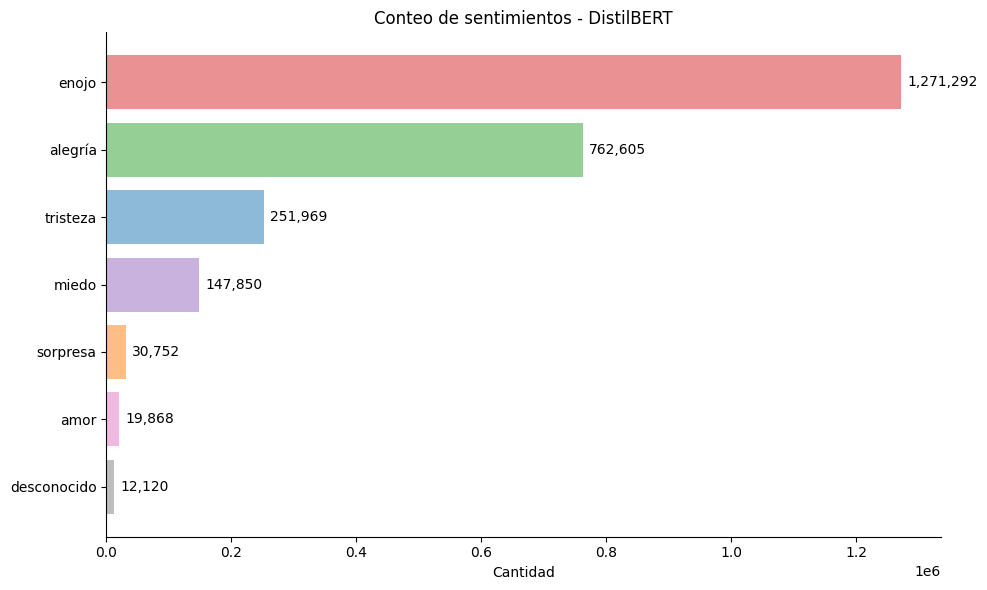

In [169]:
plot_emotions_count(df_distilbert_emotion_count, title="Conteo de sentimientos - DistilBERT")

<Figure size 1400x600 with 0 Axes>

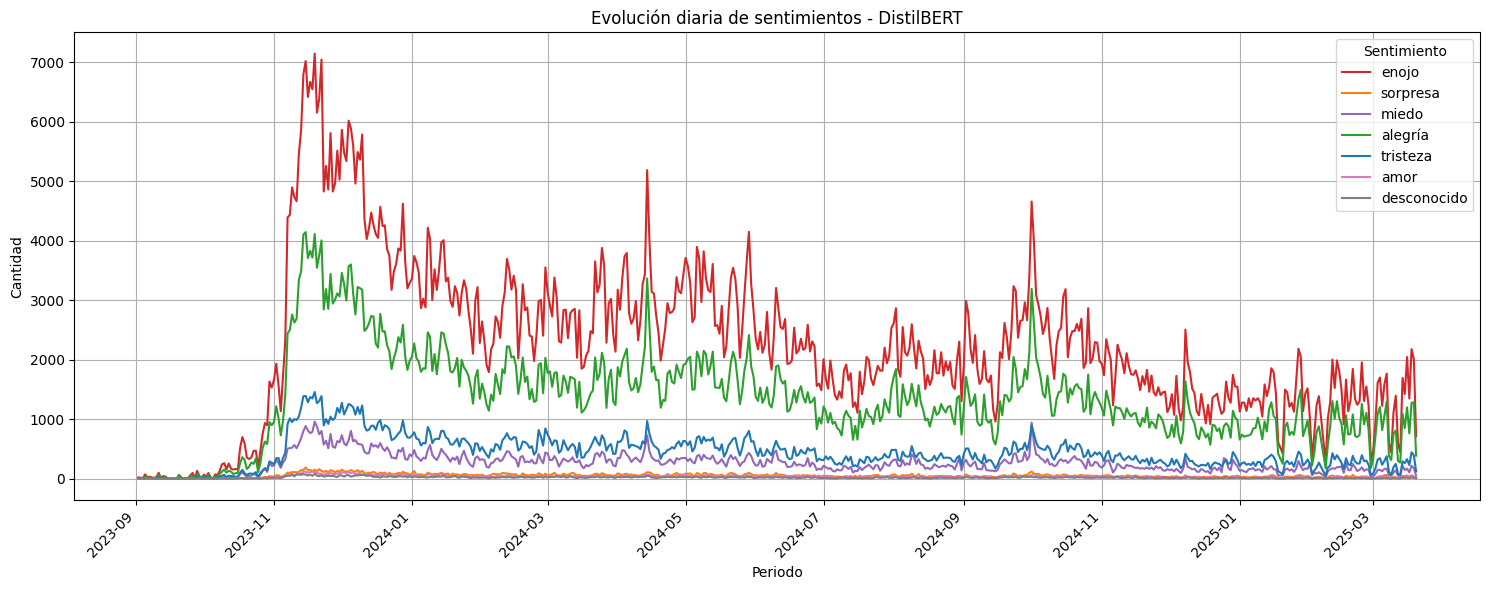

<Figure size 1400x600 with 0 Axes>

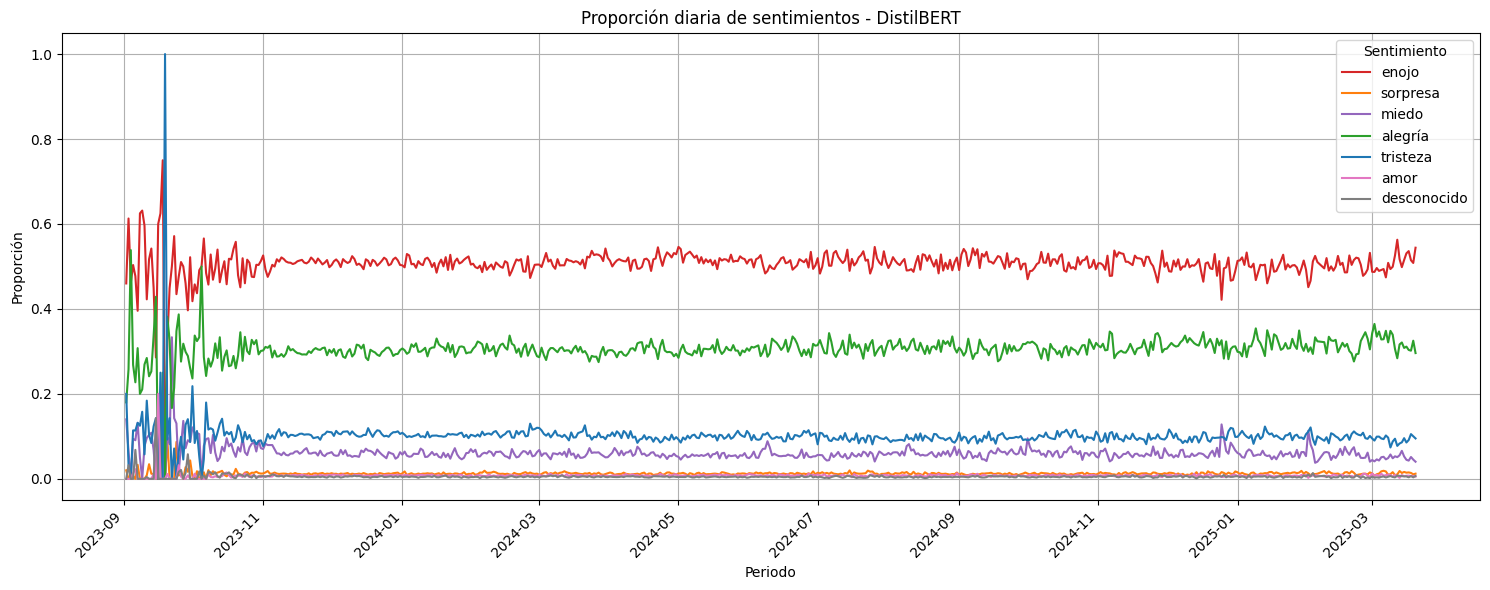

<Figure size 1400x600 with 0 Axes>

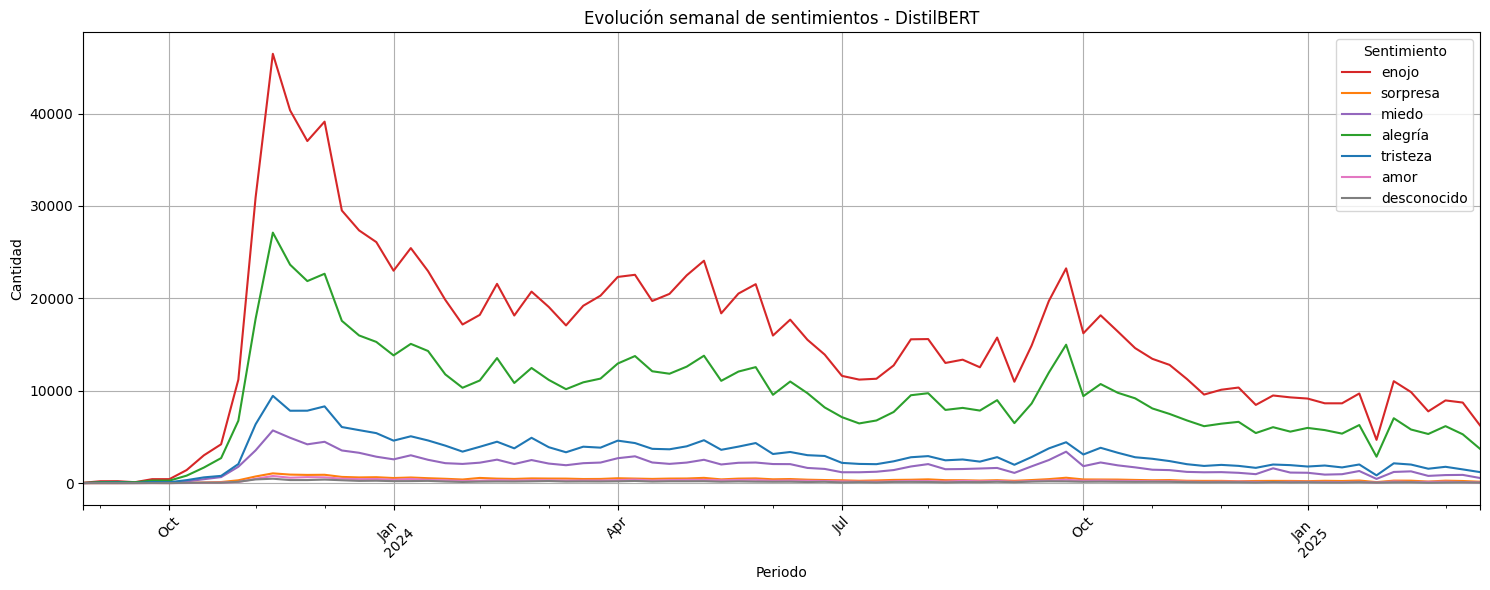

<Figure size 1400x600 with 0 Axes>

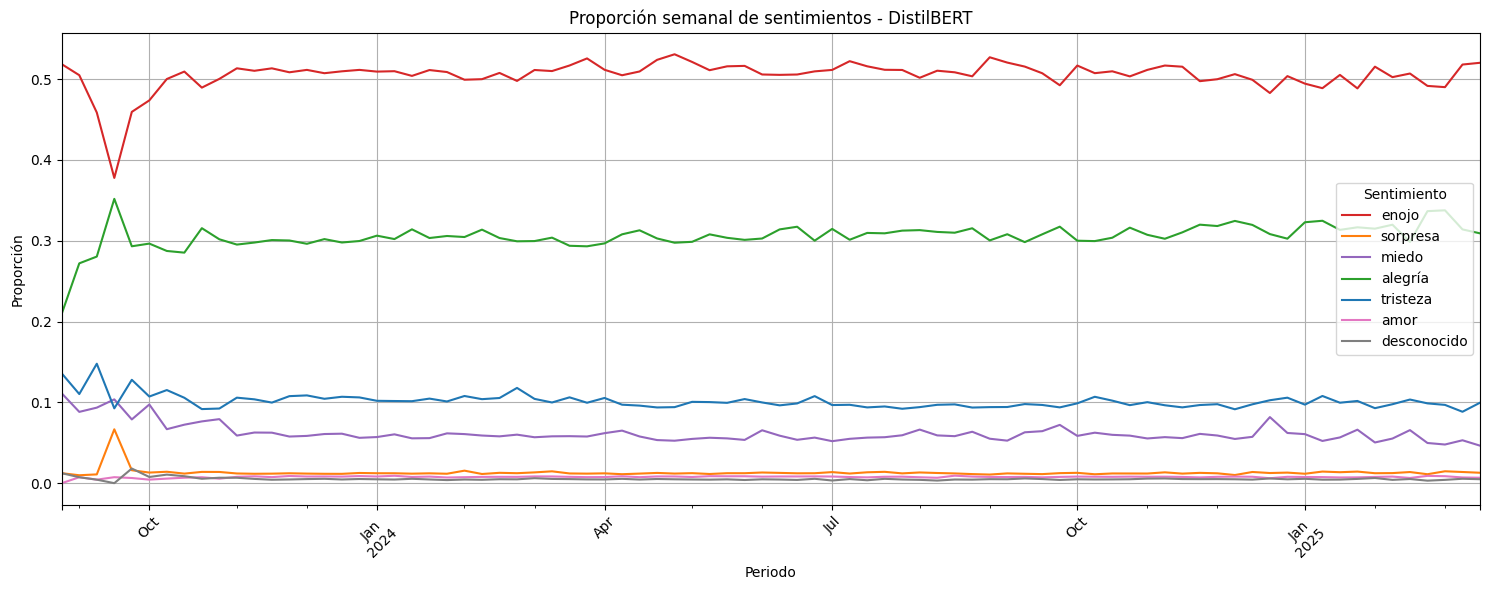

<Figure size 1400x600 with 0 Axes>

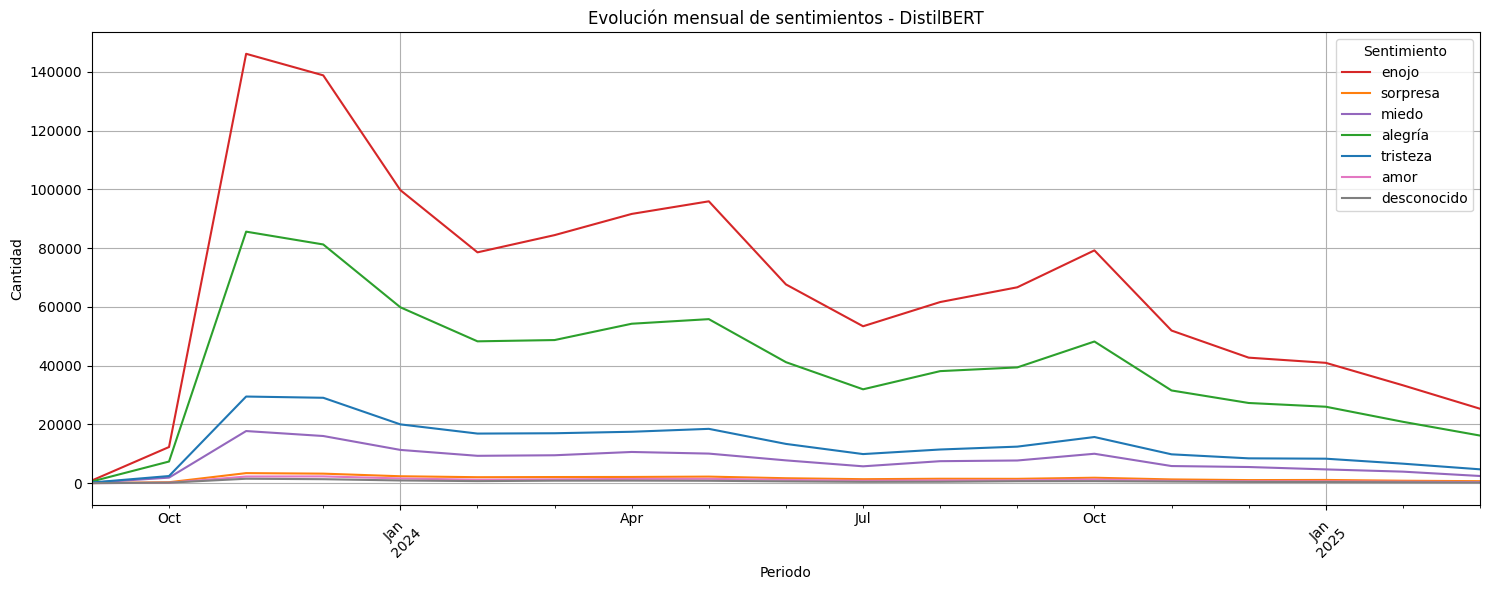

<Figure size 1400x600 with 0 Axes>

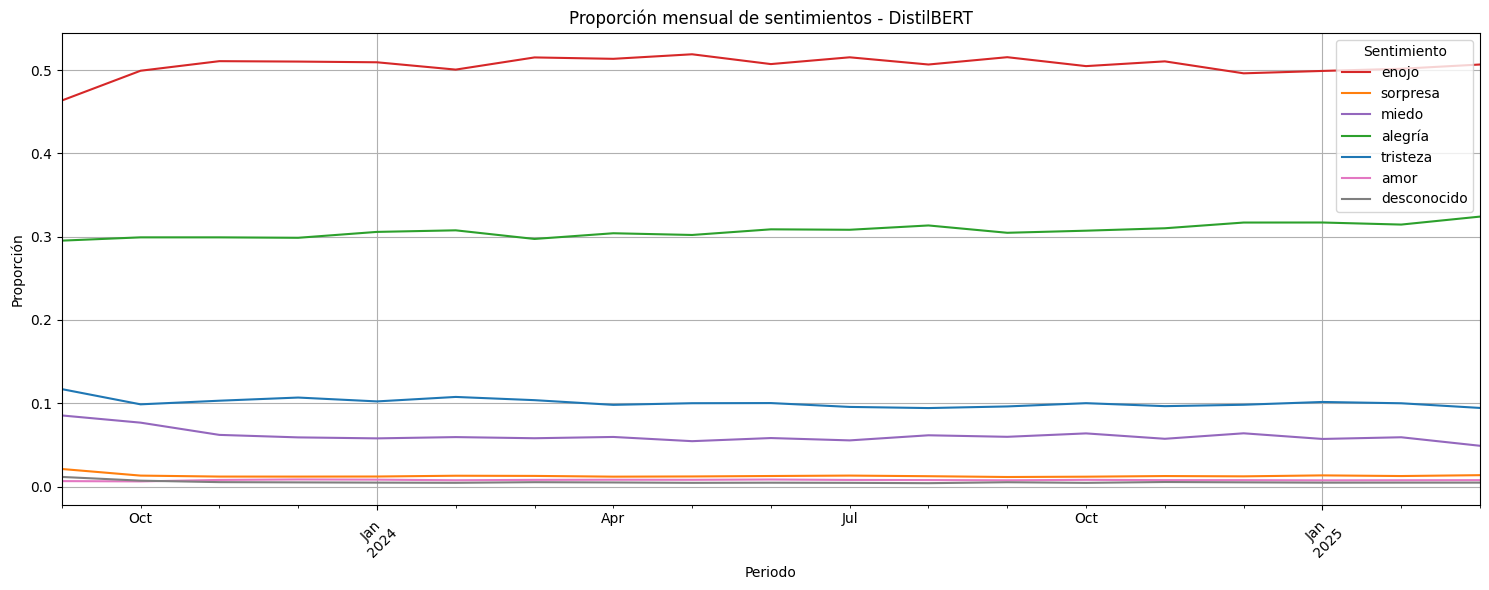

In [170]:
# Diario
daily_counts_distilbert = process_emotion_counts_by_period(df_distilbert_translated, period="D")
plot_emotion_counts_by_period(daily_counts_distilbert, "Evolución diaria de sentimientos - DistilBERT")
plot_emotion_proportions_by_period(daily_counts_distilbert, "Proporción diaria de sentimientos - DistilBERT")

# Semanal
weekly_counts_distilbert = process_emotion_counts_by_period(df_distilbert_translated, period="W")
plot_emotion_counts_by_period(weekly_counts_distilbert, "Evolución semanal de sentimientos - DistilBERT")
plot_emotion_proportions_by_period(weekly_counts_distilbert, "Proporción semanal de sentimientos - DistilBERT")

# Mensual
monthly_counts_distilbert = process_emotion_counts_by_period(df_distilbert_translated, period="M")
plot_emotion_counts_by_period(monthly_counts_distilbert, "Evolución mensual de sentimientos - DistilBERT")
plot_emotion_proportions_by_period(monthly_counts_distilbert, "Proporción mensual de sentimientos - DistilBERT")

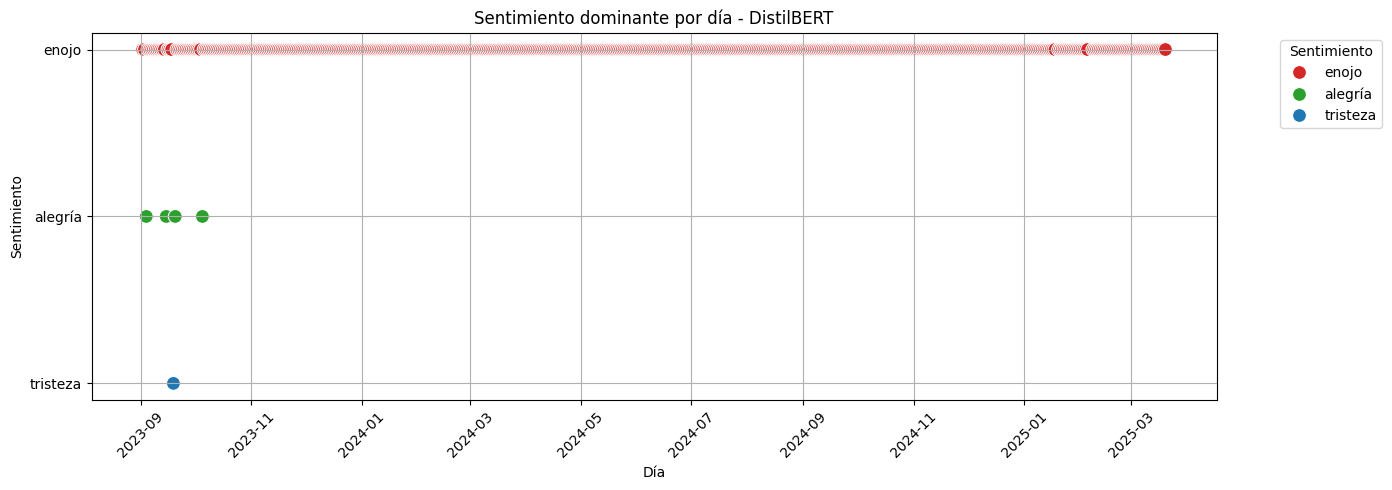

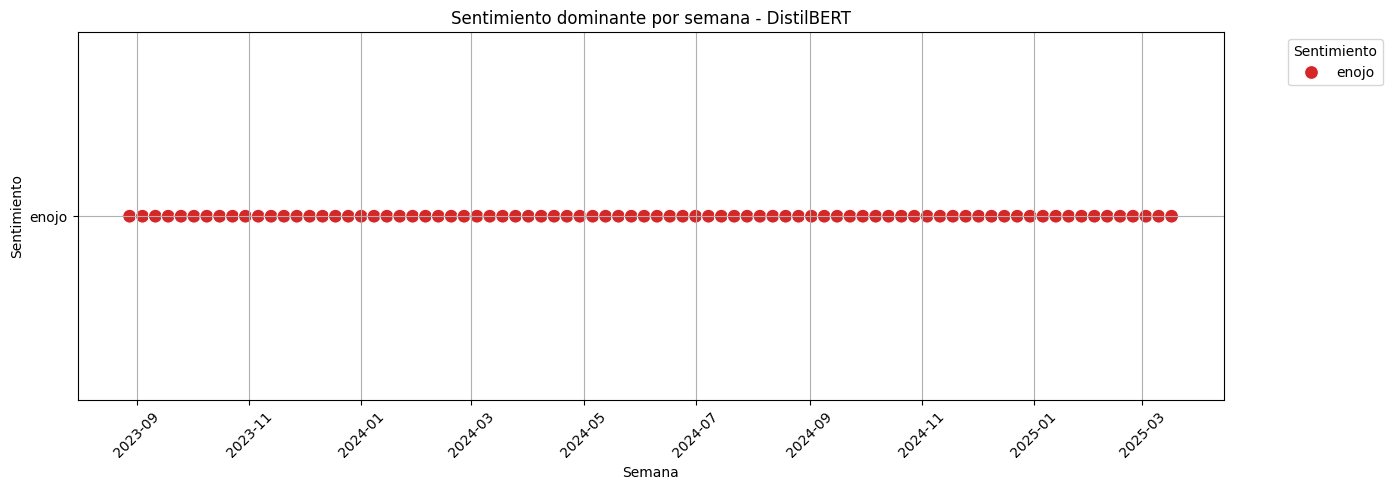

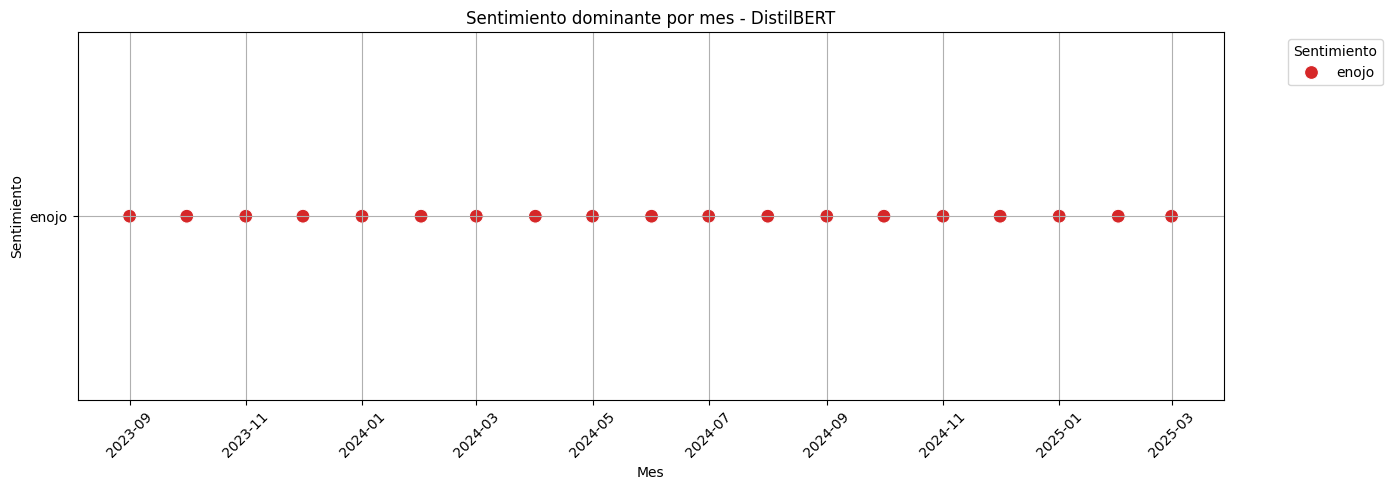

In [190]:
# Para datos diarios
plot_dominant_emotion(
    daily_counts_distilbert,
    title="Sentimiento dominante por día - DistilBERT",
    x_label="Día",
    period_type="día"
)

# Para datos semanales
plot_dominant_emotion(
    weekly_counts_distilbert,
    title="Sentimiento dominante por semana - DistilBERT",
    x_label="Semana",
    period_type="semana"
)

# Para datos mensuales
plot_dominant_emotion(
    monthly_counts_distilbert,
    title="Sentimiento dominante por mes - DistilBERT",
    x_label="Mes",
    period_type="mes"
)

## Modelo T5

In [172]:
df_t5 = pd.read_csv("../data/chunks_t5/reddit_emotions_replace.csv")
df_t5_translated = translate_emotions(df_t5, "predicted_emotion")

df_t5_emotion_count = get_emotions_count(df_t5_translated, "predicted_emotion")

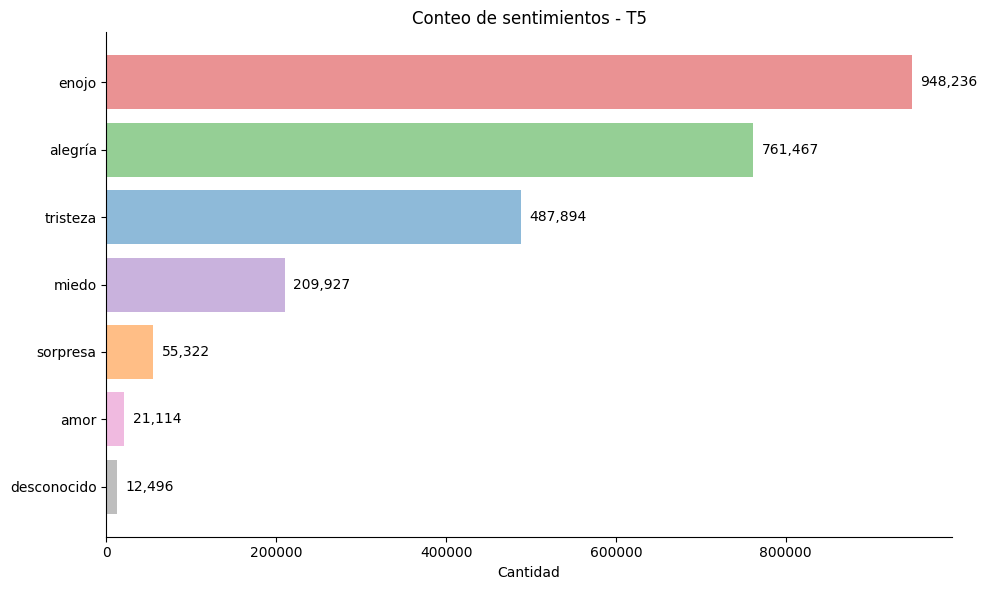

In [173]:
plot_emotions_count(df_t5_emotion_count, title="Conteo de sentimientos - T5")

<Figure size 1400x600 with 0 Axes>

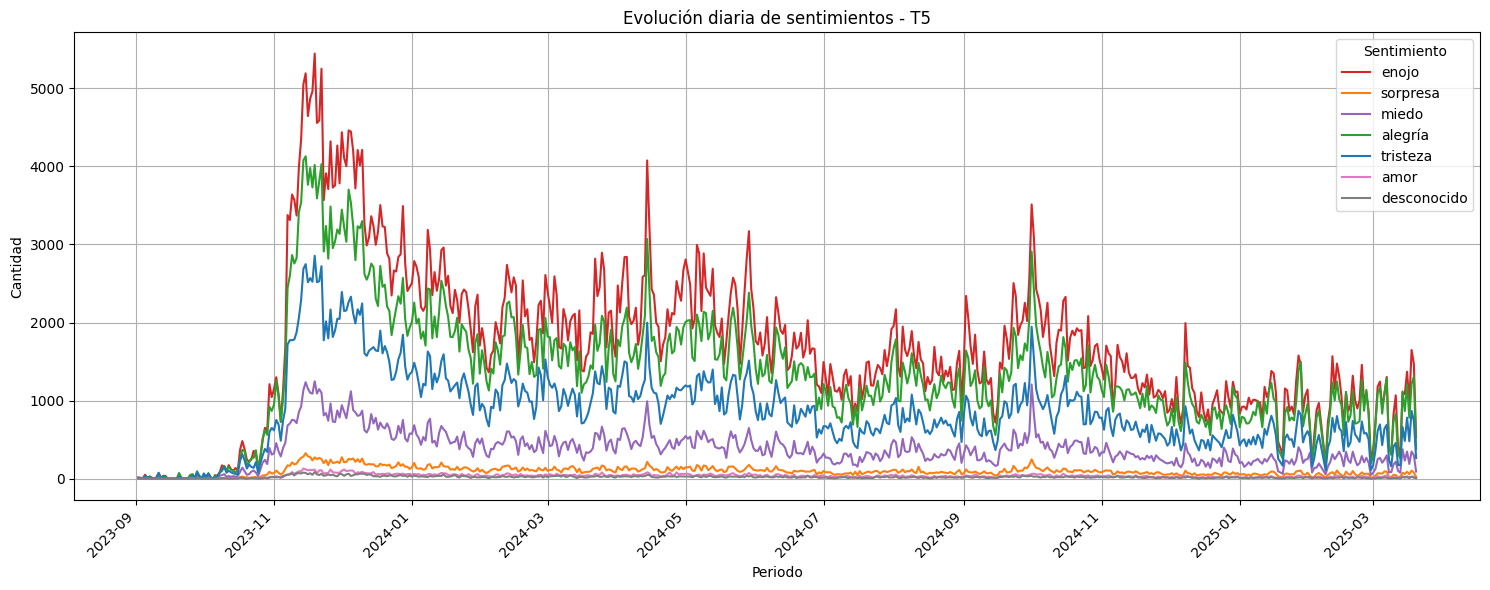

<Figure size 1400x600 with 0 Axes>

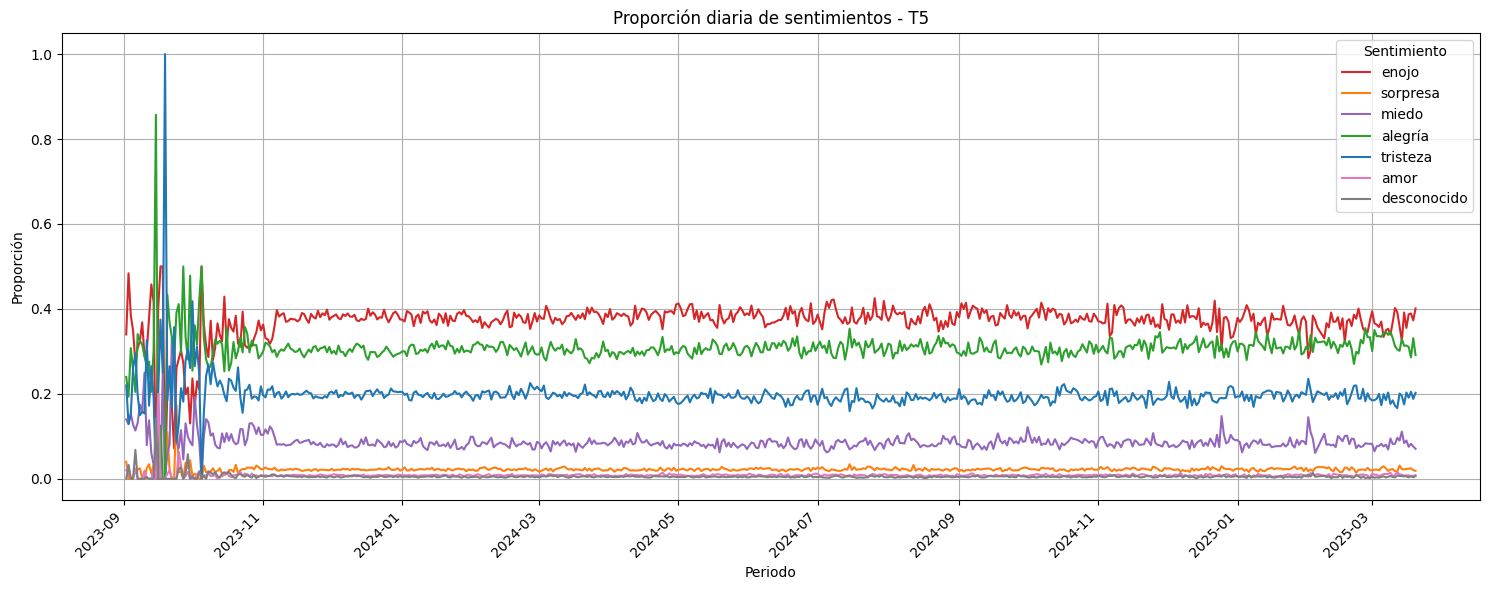

<Figure size 1400x600 with 0 Axes>

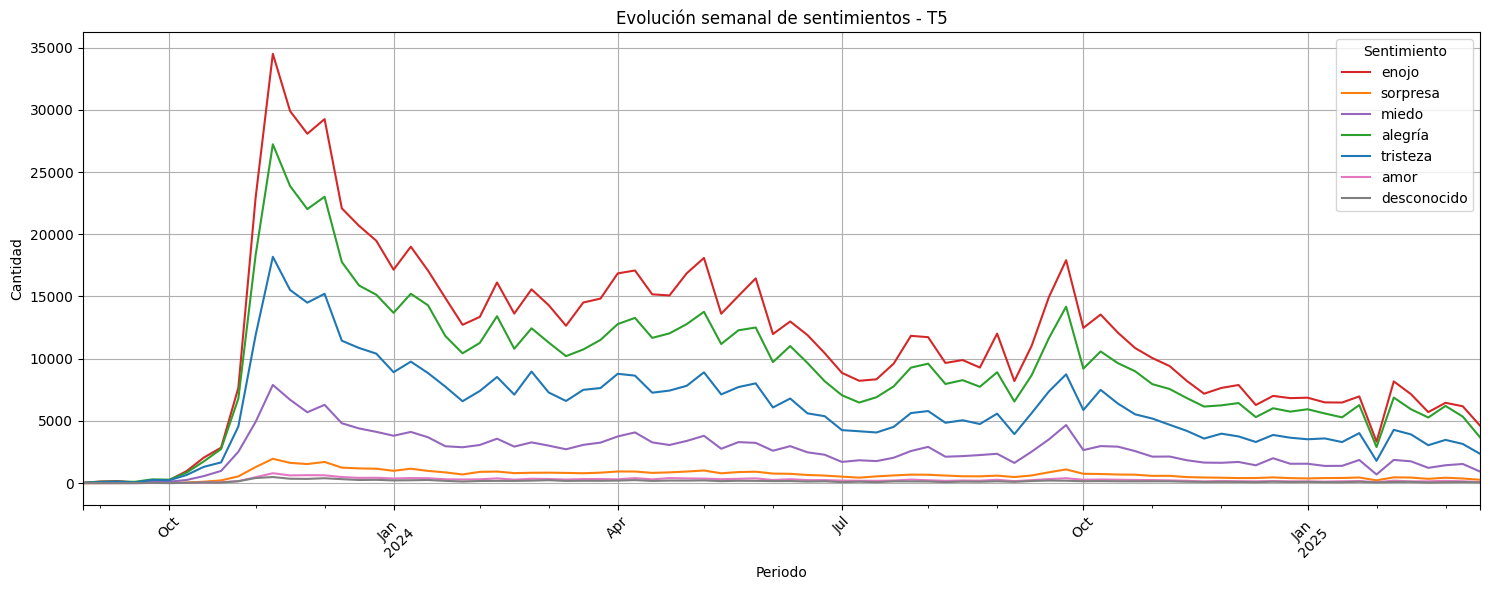

<Figure size 1400x600 with 0 Axes>

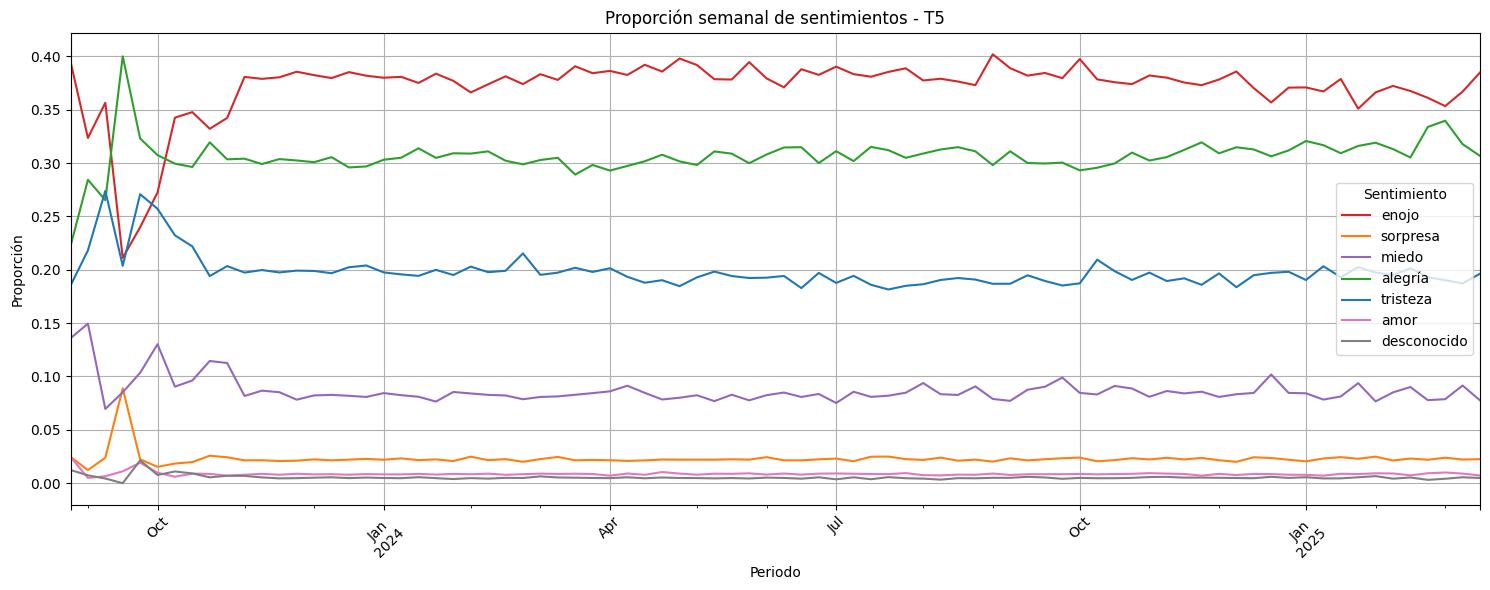

<Figure size 1400x600 with 0 Axes>

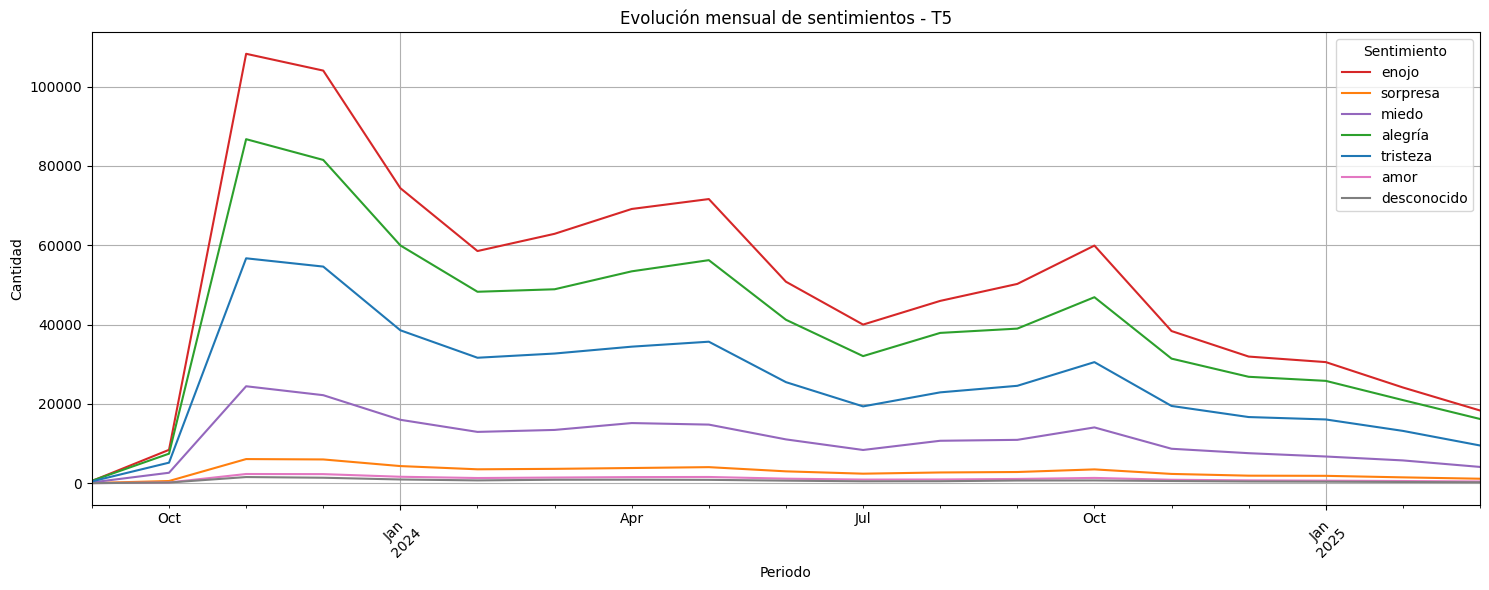

<Figure size 1400x600 with 0 Axes>

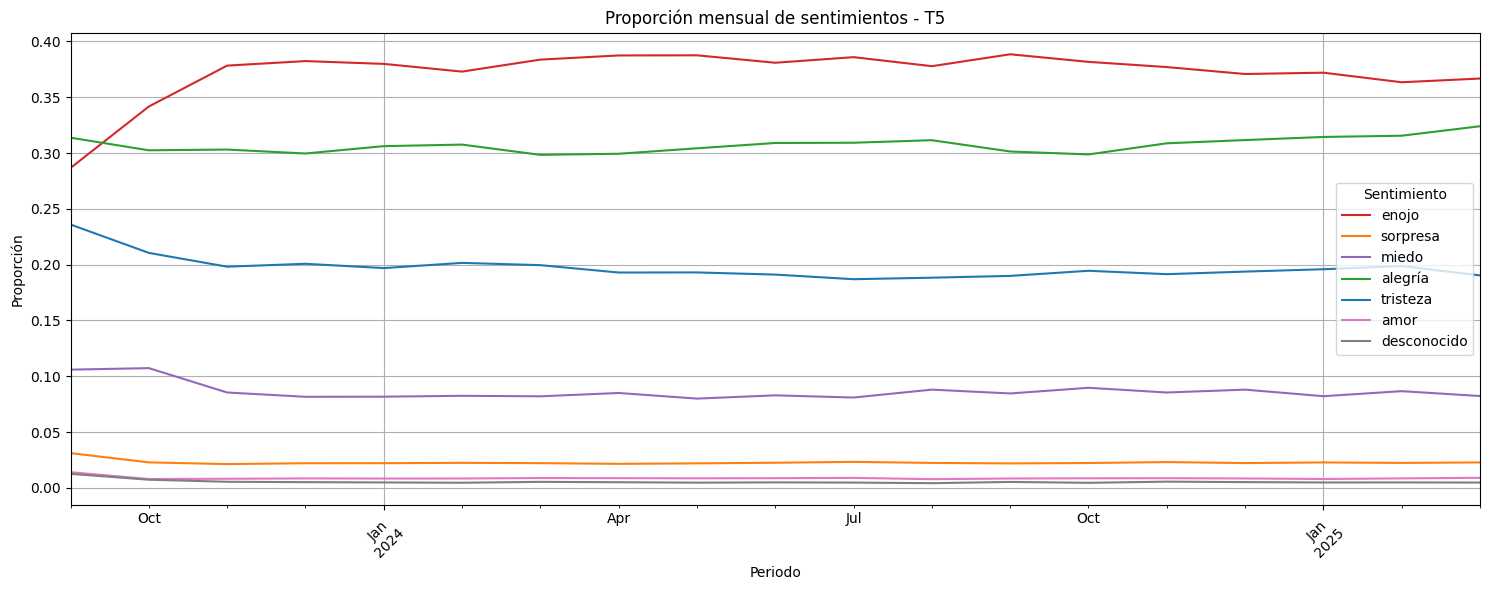

In [174]:
# Diario
daily_counts_t5 = process_emotion_counts_by_period(df_t5_translated, period="D")
plot_emotion_counts_by_period(daily_counts_t5, "Evolución diaria de sentimientos - T5")
plot_emotion_proportions_by_period(daily_counts_t5, "Proporción diaria de sentimientos - T5")

# Semanal
weekly_counts_t5 = process_emotion_counts_by_period(df_t5_translated, period="W")
plot_emotion_counts_by_period(weekly_counts_t5, "Evolución semanal de sentimientos - T5")
plot_emotion_proportions_by_period(weekly_counts_t5, "Proporción semanal de sentimientos - T5")

# Mensual
monthly_counts_t5 = process_emotion_counts_by_period(df_t5_translated, period="M")
plot_emotion_counts_by_period(monthly_counts_t5, "Evolución mensual de sentimientos - T5")
plot_emotion_proportions_by_period(monthly_counts_t5, "Proporción mensual de sentimientos - T5")

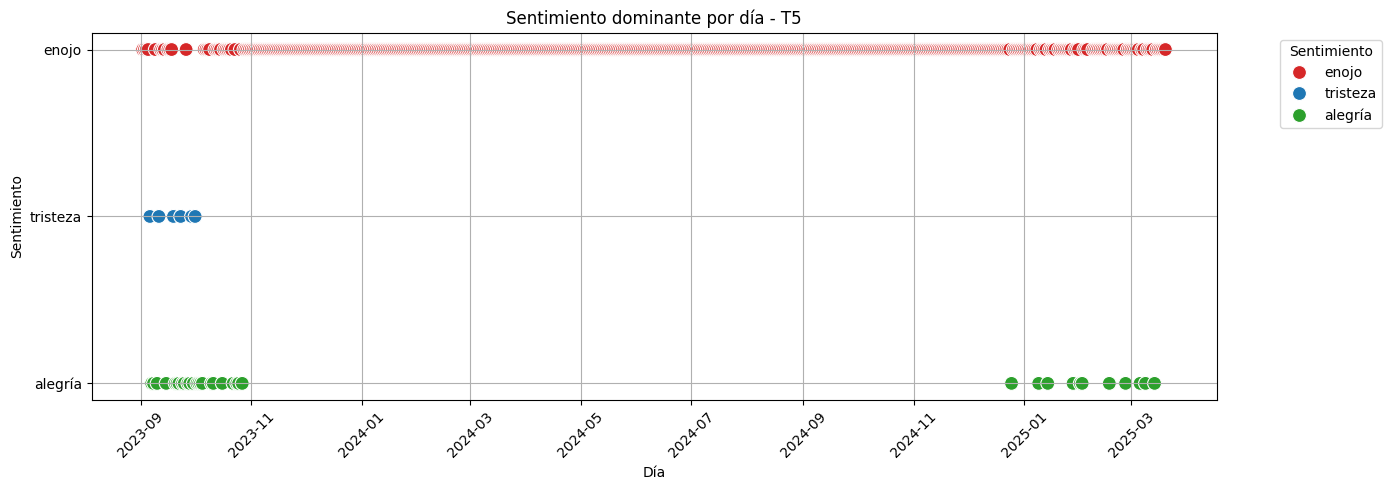

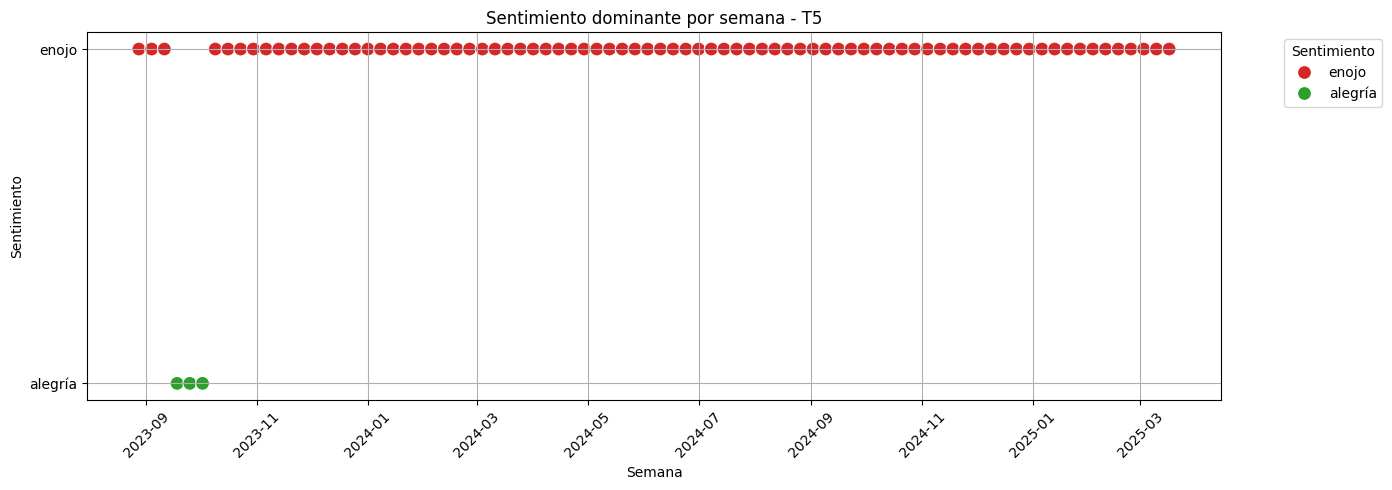

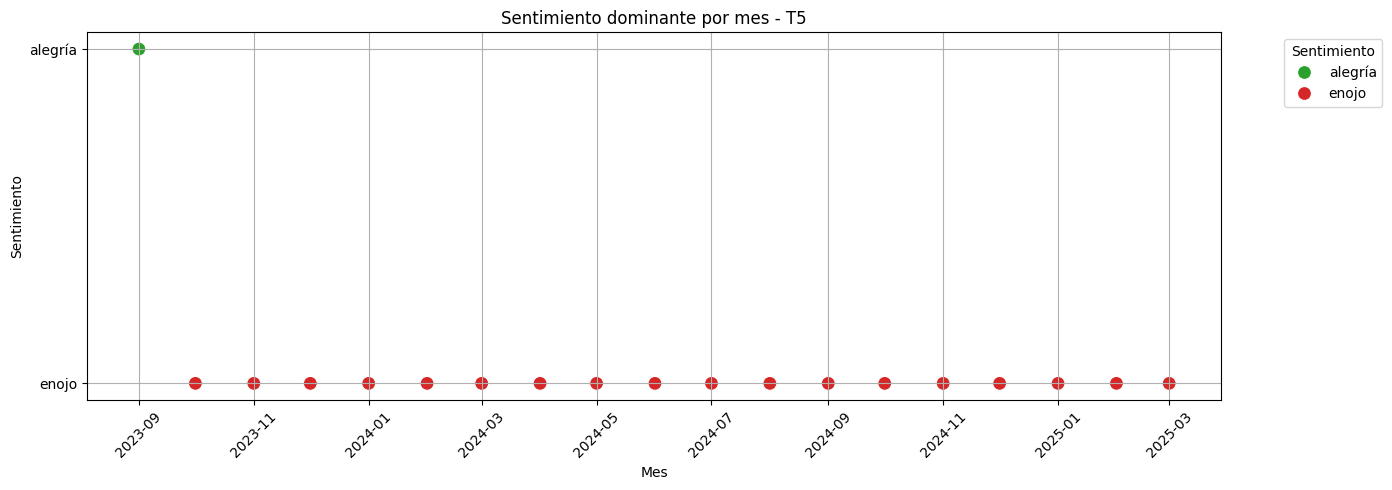

In [191]:
# Para datos diarios
plot_dominant_emotion(
    daily_counts_t5,
    title="Sentimiento dominante por día - T5",
    x_label="Día",
    period_type="día"
)
# Para datos semanales
plot_dominant_emotion(
    weekly_counts_t5,
    title="Sentimiento dominante por semana - T5",
    x_label="Semana",
    period_type="semana"
)
# Para datos mensuales
plot_dominant_emotion(
    monthly_counts_t5,
    title="Sentimiento dominante por mes - T5",
    x_label="Mes",
    period_type="mes"
)

## Modelo Roberta

In [176]:
df_roberta = pd.read_csv("../data/chunks_roberta/reddit_emotions.csv")
df_roberta_translated = translate_emotions(df_roberta, "predicted_emotion")

df_roberta_emotion_count = get_emotions_count(df_roberta_translated, "predicted_emotion")

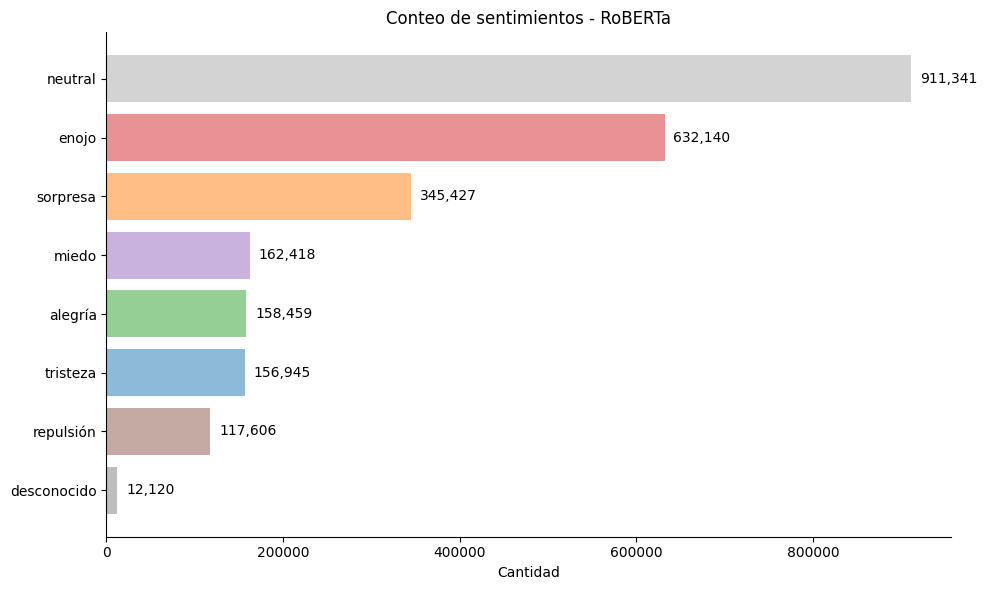

In [177]:
plot_emotions_count(df_roberta_emotion_count, title="Conteo de sentimientos - RoBERTa")

<Figure size 1400x600 with 0 Axes>

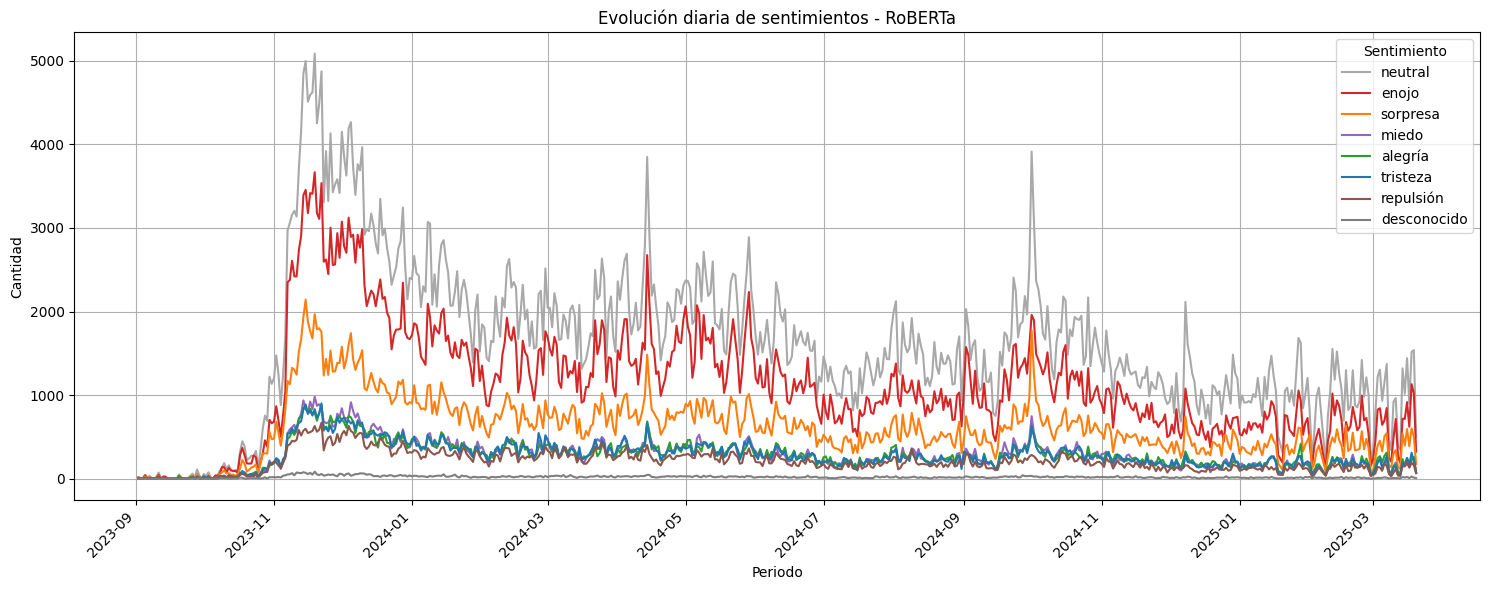

<Figure size 1400x600 with 0 Axes>

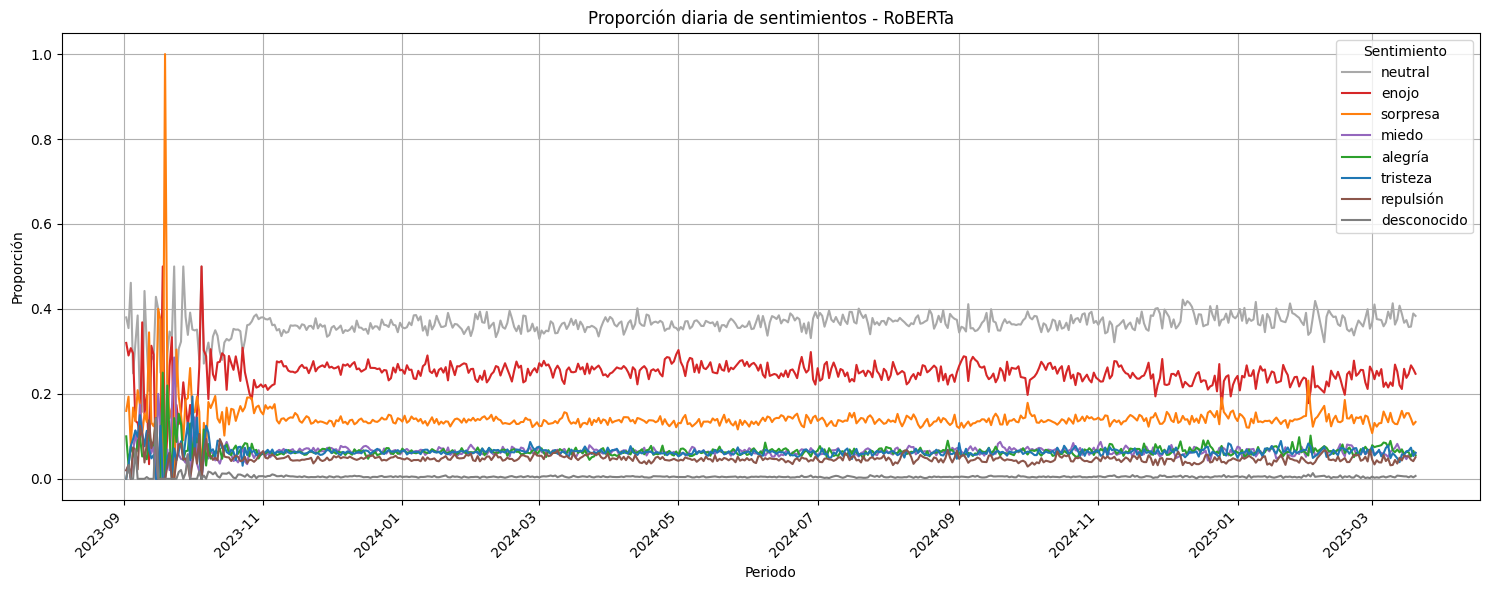

<Figure size 1400x600 with 0 Axes>

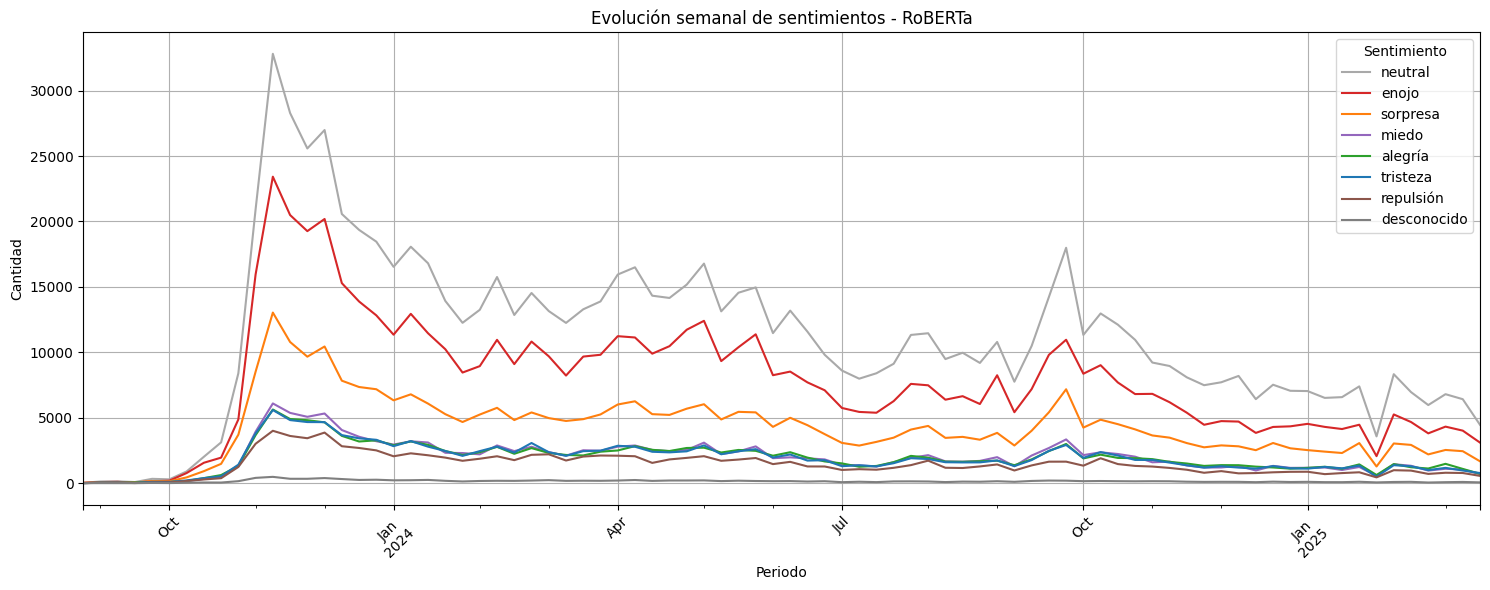

<Figure size 1400x600 with 0 Axes>

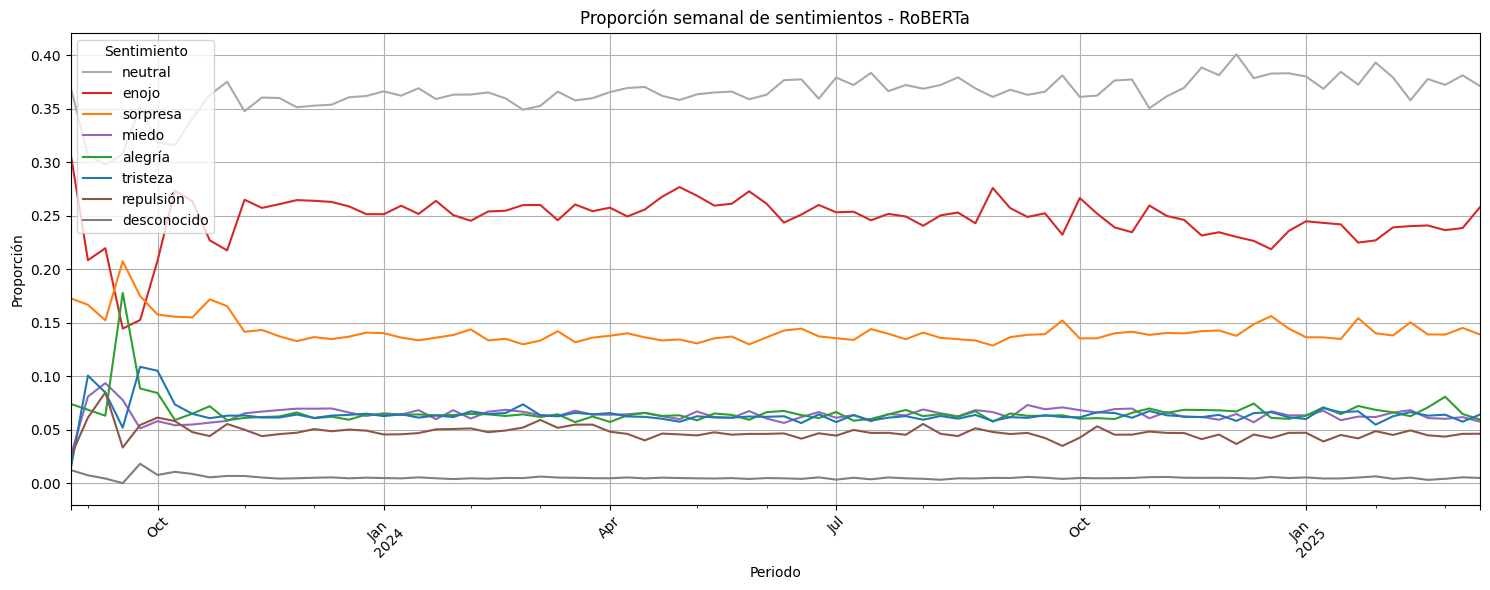

<Figure size 1400x600 with 0 Axes>

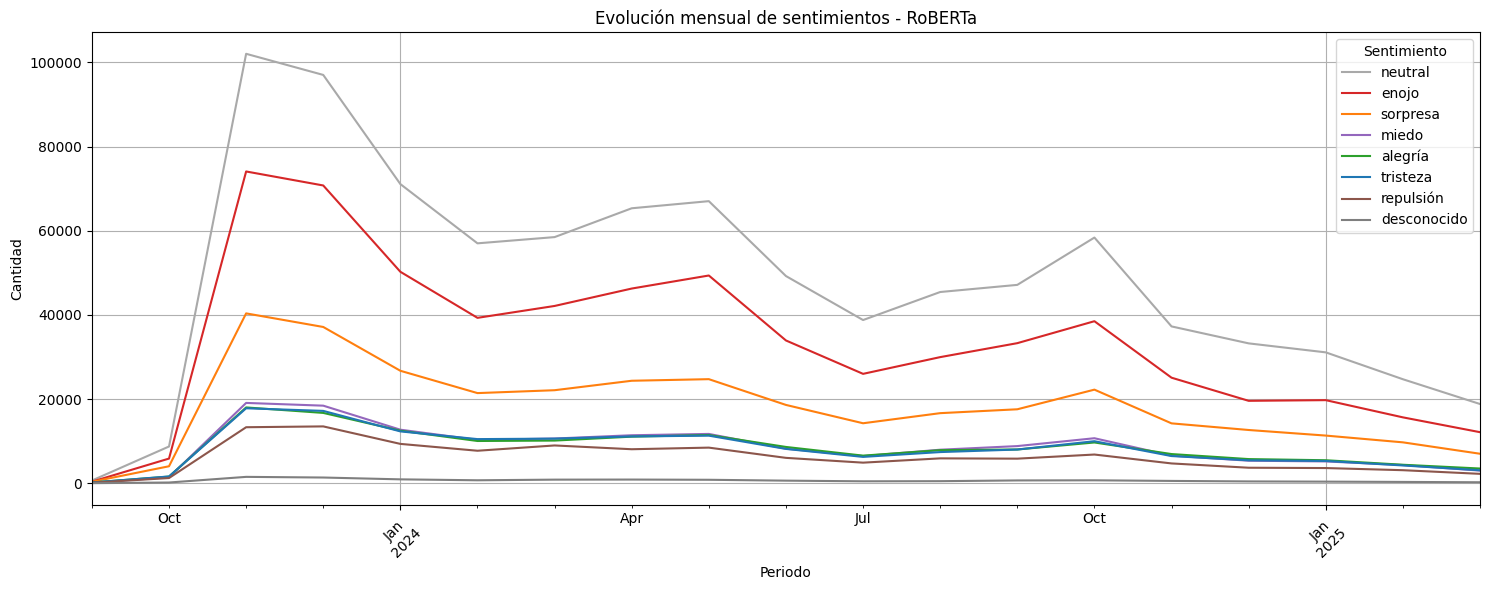

<Figure size 1400x600 with 0 Axes>

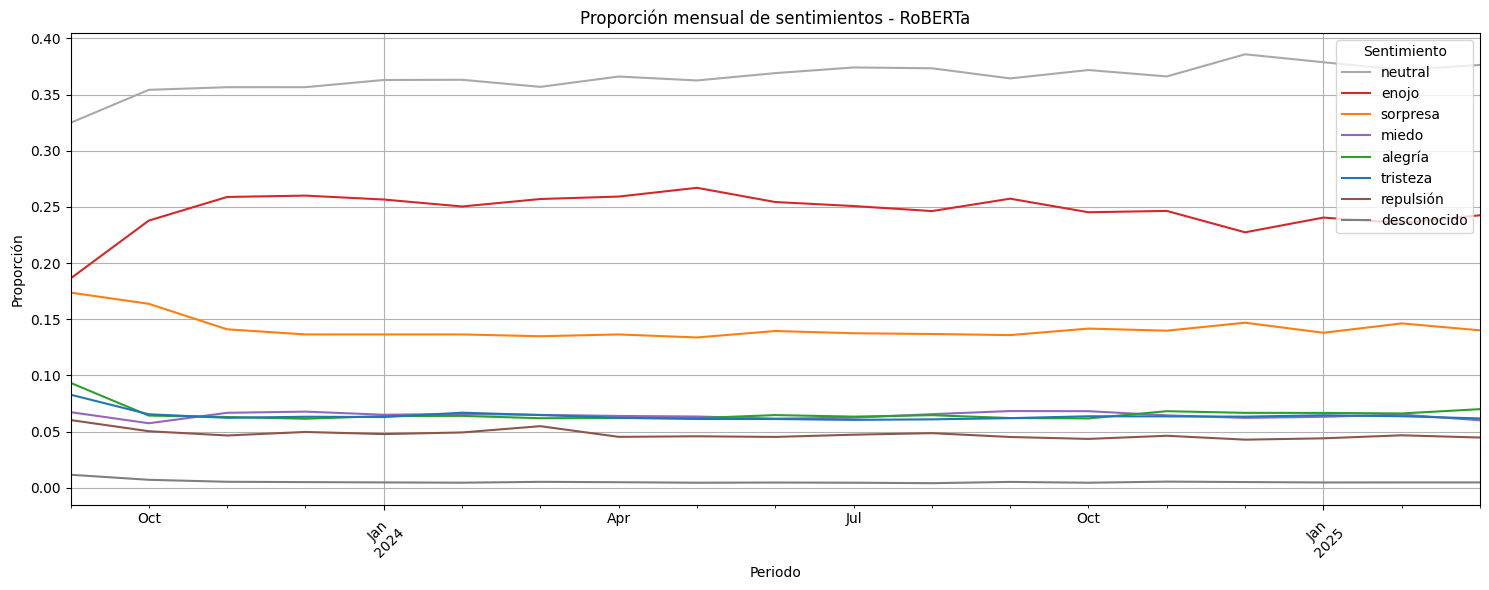

In [178]:
# Diario
daily_counts_roberta = process_emotion_counts_by_period(df_roberta_translated, period="D")
plot_emotion_counts_by_period(daily_counts_roberta, "Evolución diaria de sentimientos - RoBERTa")
plot_emotion_proportions_by_period(daily_counts_roberta, "Proporción diaria de sentimientos - RoBERTa")

# Semanal
weekly_counts_roberta = process_emotion_counts_by_period(df_roberta_translated, period="W")
plot_emotion_counts_by_period(weekly_counts_roberta, "Evolución semanal de sentimientos - RoBERTa")
plot_emotion_proportions_by_period(weekly_counts_roberta, "Proporción semanal de sentimientos - RoBERTa")

# Mensual
monthly_counts_roberta = process_emotion_counts_by_period(df_roberta_translated, period="M")
plot_emotion_counts_by_period(monthly_counts_roberta, "Evolución mensual de sentimientos - RoBERTa")
plot_emotion_proportions_by_period(monthly_counts_roberta, "Proporción mensual de sentimientos - RoBERTa")

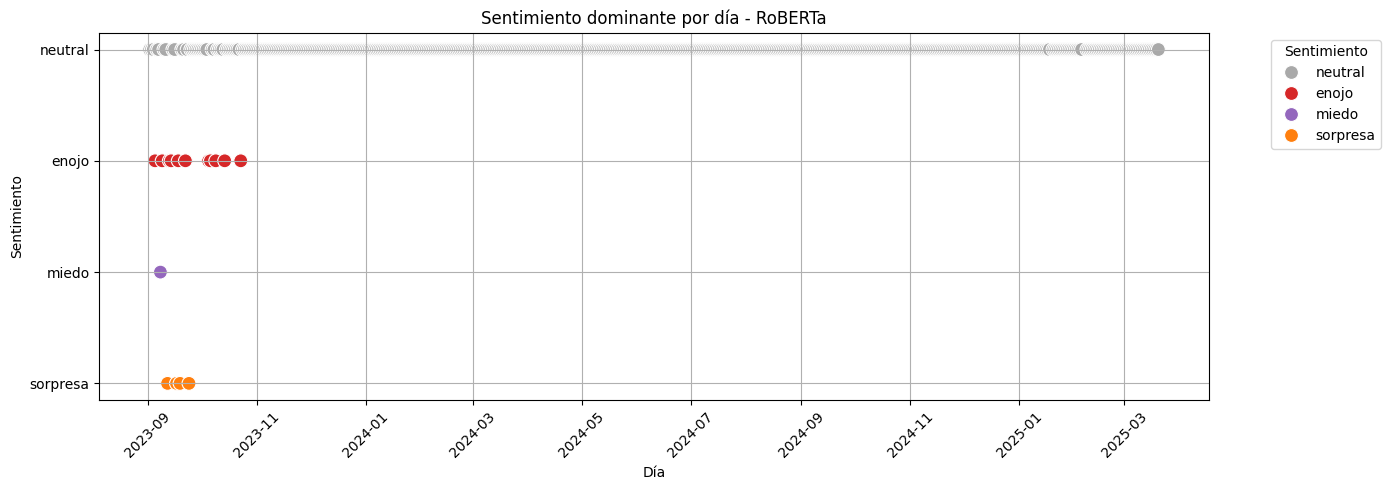

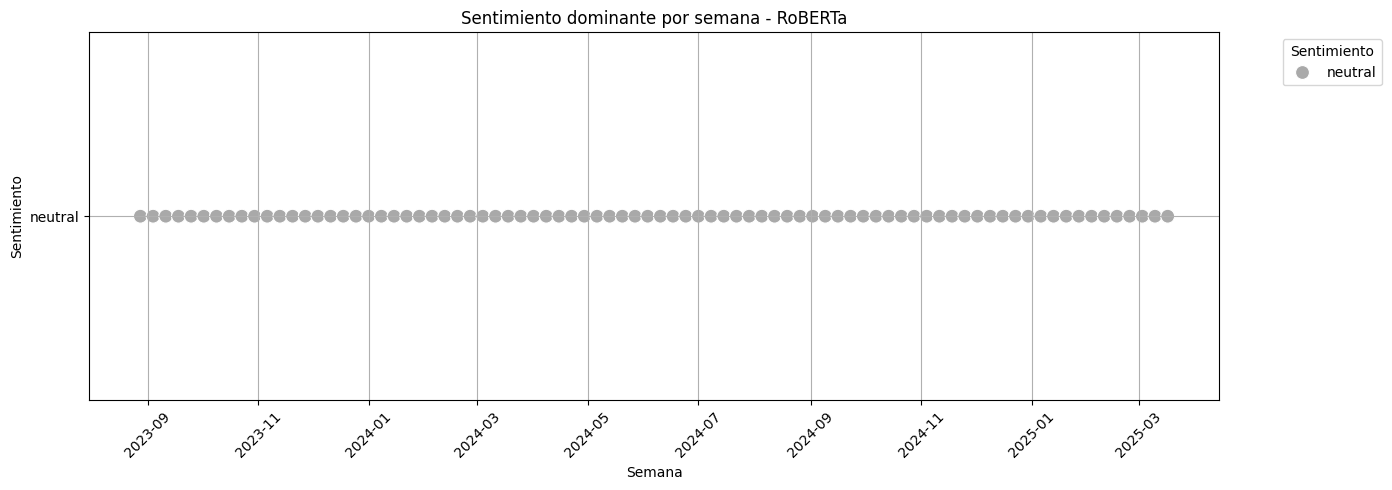

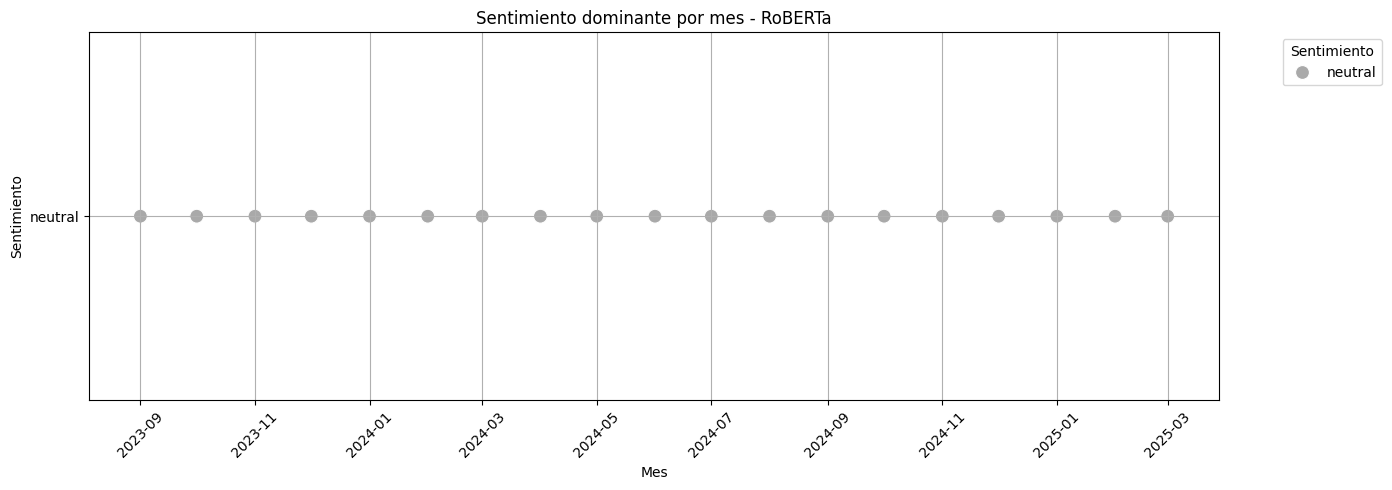

In [193]:
# Para datos diarios
plot_dominant_emotion(
    daily_counts_roberta,
    title="Sentimiento dominante por día - RoBERTa",
    x_label="Día",
    period_type="día",
)
# Para datos semanales
plot_dominant_emotion(
    weekly_counts_roberta,
    title="Sentimiento dominante por semana - RoBERTa",
    x_label="Semana",
    period_type="semana"
)
# Para datos mensuales
plot_dominant_emotion(
    monthly_counts_roberta,
    title="Sentimiento dominante por mes - RoBERTa",
    x_label="Mes",
    period_type="mes"
)

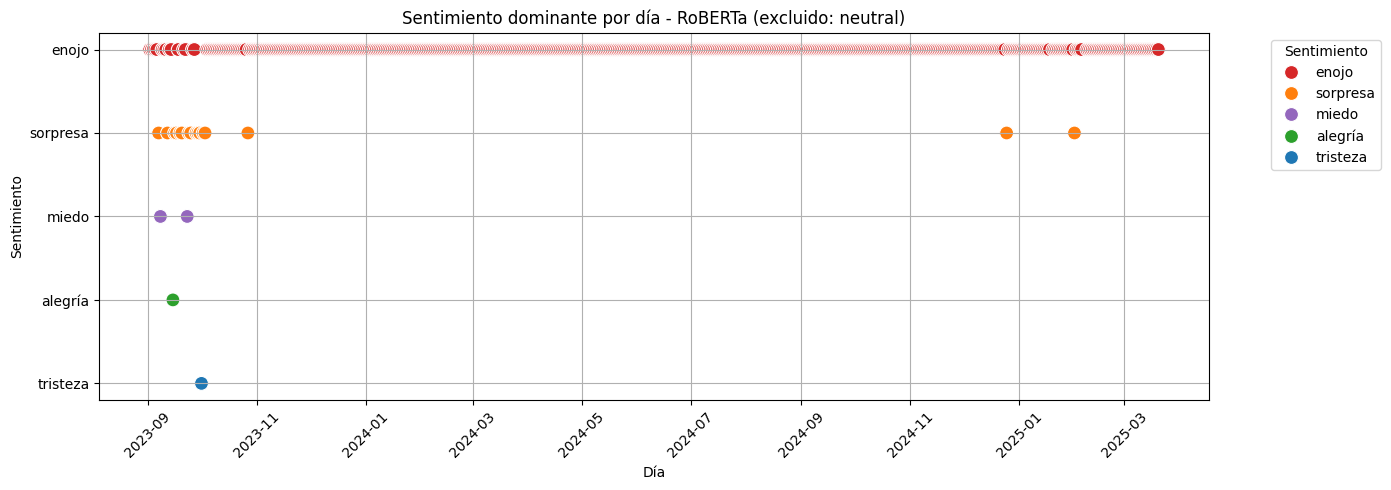

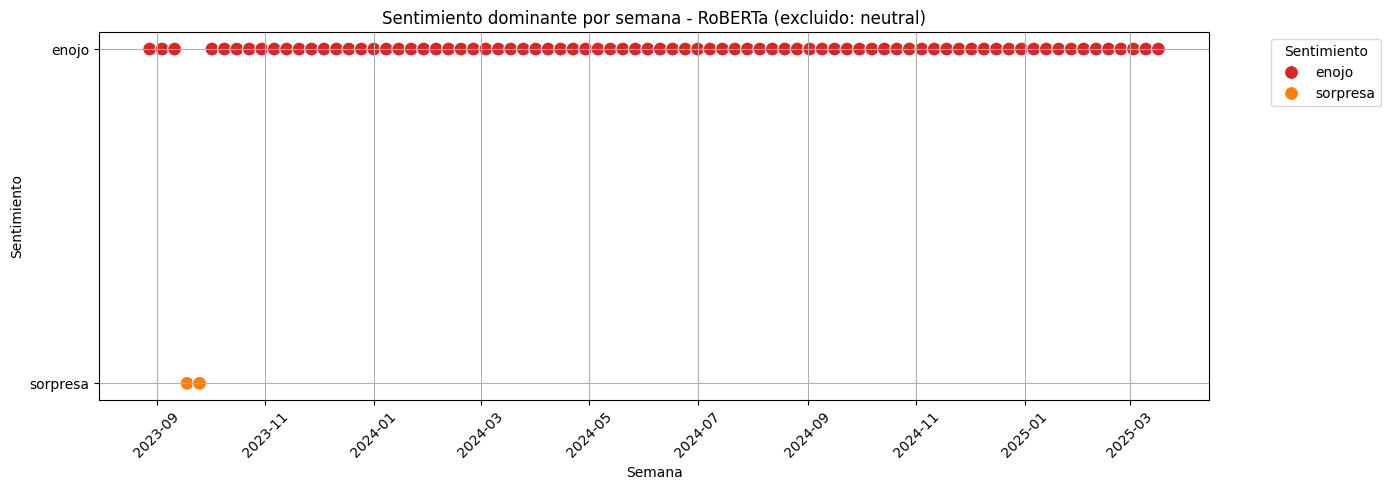

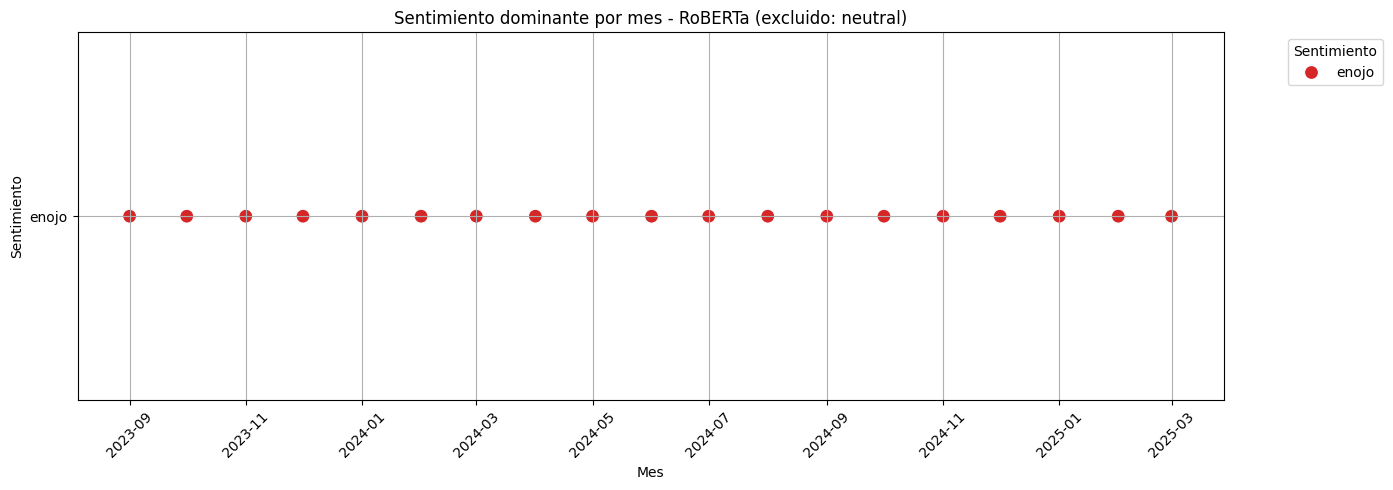

In [194]:
# Para datos diarios
plot_dominant_emotion(
    daily_counts_roberta,
    title="Sentimiento dominante por día - RoBERTa",
    x_label="Día",
    period_type="día",
    exclude_emotions=["neutral"]
)
# Para datos semanales
plot_dominant_emotion(
    weekly_counts_roberta,
    title="Sentimiento dominante por semana - RoBERTa",
    x_label="Semana",
    period_type="semana",
    exclude_emotions=["neutral"]
)
# Para datos mensuales
plot_dominant_emotion(
    monthly_counts_roberta,
    title="Sentimiento dominante por mes - RoBERTa",
    x_label="Mes",
    period_type="mes",
    exclude_emotions=["neutral"]
)

In [181]:
props_distilbert = get_monthly_proportions(df_distilbert, "DistilBERT")
props_t5         = get_monthly_proportions(df_t5, "T5")
props_roberta    = get_monthly_proportions(df_roberta, "RoBERTa")


Proporciones promedio mensuales – DistilBERT
predicted_emotion
enojo          0.5054
alegría        0.3070
tristeza       0.1007
miedo          0.0609
sorpresa       0.0129
amor           0.0077
desconocido    0.0053
dtype: float64

Proporciones promedio mensuales – T5
predicted_emotion
enojo          0.3719
alegría        0.3073
tristeza       0.1974
miedo          0.0864
sorpresa       0.0228
amor           0.0087
desconocido    0.0055
dtype: float64

Proporciones promedio mensuales – RoBERTa
predicted_emotion
neutral        0.3650
enojo          0.2463
sorpresa       0.1418
alegría        0.0657
miedo          0.0643
tristeza       0.0640
repulsión      0.0475
desconocido    0.0053
dtype: float64


In [196]:
# Execute peak detection
peaks_distilbert_multiple = detect_multiple_peaks(monthly_counts_distilbert, model="DistilBERT", prominence=10000)
peaks_roberta_multiple = detect_multiple_peaks(monthly_counts_roberta, model="RoBERTa", prominence=10000)
peaks_t5_multiple = detect_multiple_peaks(monthly_counts_t5, model="T5", prominence=10000)

# Convert to DataFrame for visualization
df_peaks_multiple = pd.DataFrame(peaks_distilbert_multiple + peaks_roberta_multiple + peaks_t5_multiple,
                                 columns=["Modelo", "Sentimiento", "Fecha", "Cantidad"])

df_peaks_multiple


Modelo Sentimiento    Fecha  Cantidad
0   DistilBERT     alegría  2023-11     85601
1   DistilBERT     alegría  2024-10     48215
2   DistilBERT       enojo  2023-11    146126
3   DistilBERT       enojo  2024-05     95925
4   DistilBERT       enojo  2024-10     79228
5   DistilBERT       miedo  2023-11     17746
6   DistilBERT    tristeza  2023-11     29487
7      RoBERTa     alegría  2023-11     18010
8      RoBERTa       enojo  2023-11     74068
9      RoBERTa       enojo  2024-05     49354
10     RoBERTa       enojo  2024-10     38496
11     RoBERTa       miedo  2023-11     19083
12     RoBERTa     neutral  2023-11    102024
13     RoBERTa     neutral  2024-05     67017
14     RoBERTa     neutral  2024-10     58368
15     RoBERTa   repulsión  2023-12     13506
16     RoBERTa    sorpresa  2023-11     40354
17     RoBERTa    tristeza  2023-11     17811
18          T5     alegría  2023-11     86747
19          T5     alegría  2024-10     46903
20          T5       enojo  2023-11    108271
21          T5       enojo  2024-05     71649
22          T5       enojo  2024-10     59923
23          T5       miedo  2023-11     24454
24          T5    tristeza  2023-11     56712
25          T5    tristeza  2024-10     30536

C:\Users\wwwde\AppData\Local\Temp\ipykernel_18768\2593354640.py:110: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colores = plt.cm.get_cmap("tab10", len(monthly_counts_model.columns))


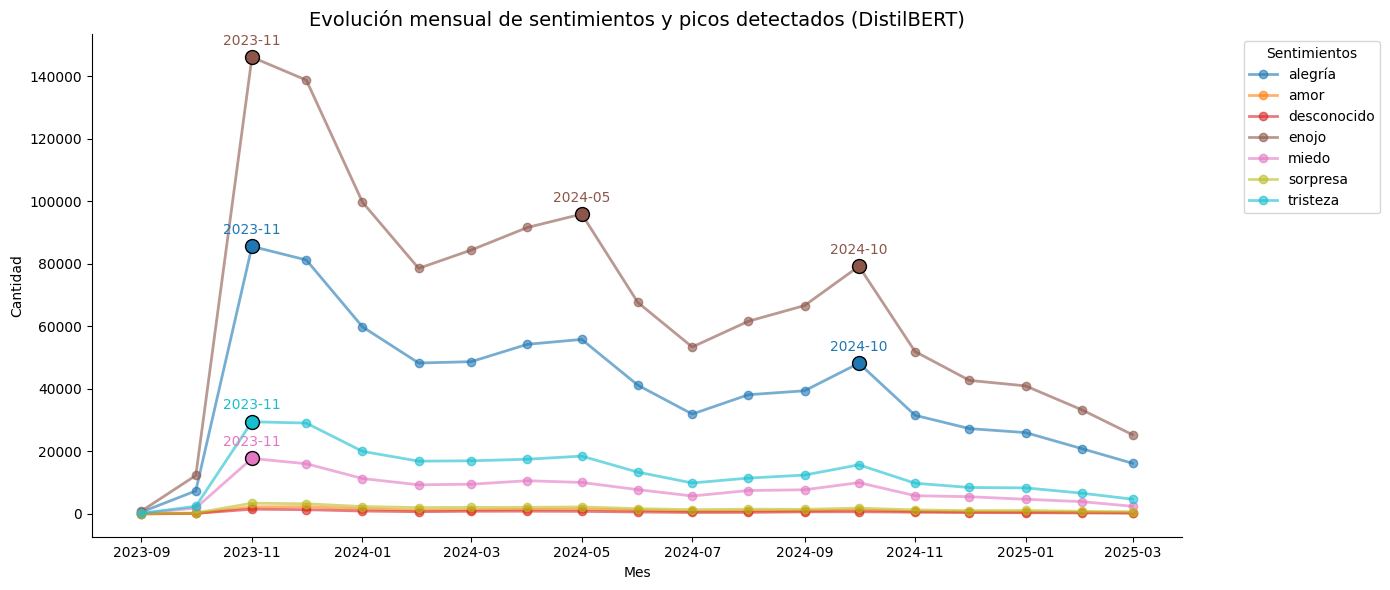

C:\Users\wwwde\AppData\Local\Temp\ipykernel_18768\2593354640.py:110: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colores = plt.cm.get_cmap("tab10", len(monthly_counts_model.columns))


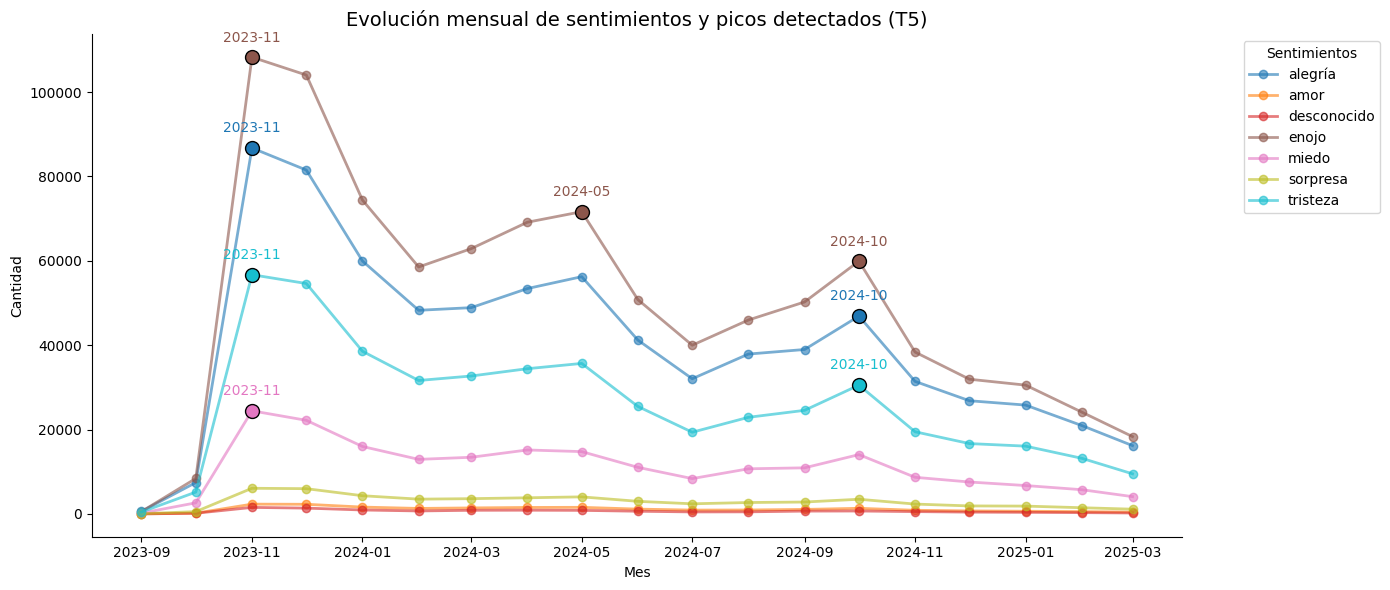

C:\Users\wwwde\AppData\Local\Temp\ipykernel_18768\2593354640.py:110: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colores = plt.cm.get_cmap("tab10", len(monthly_counts_model.columns))


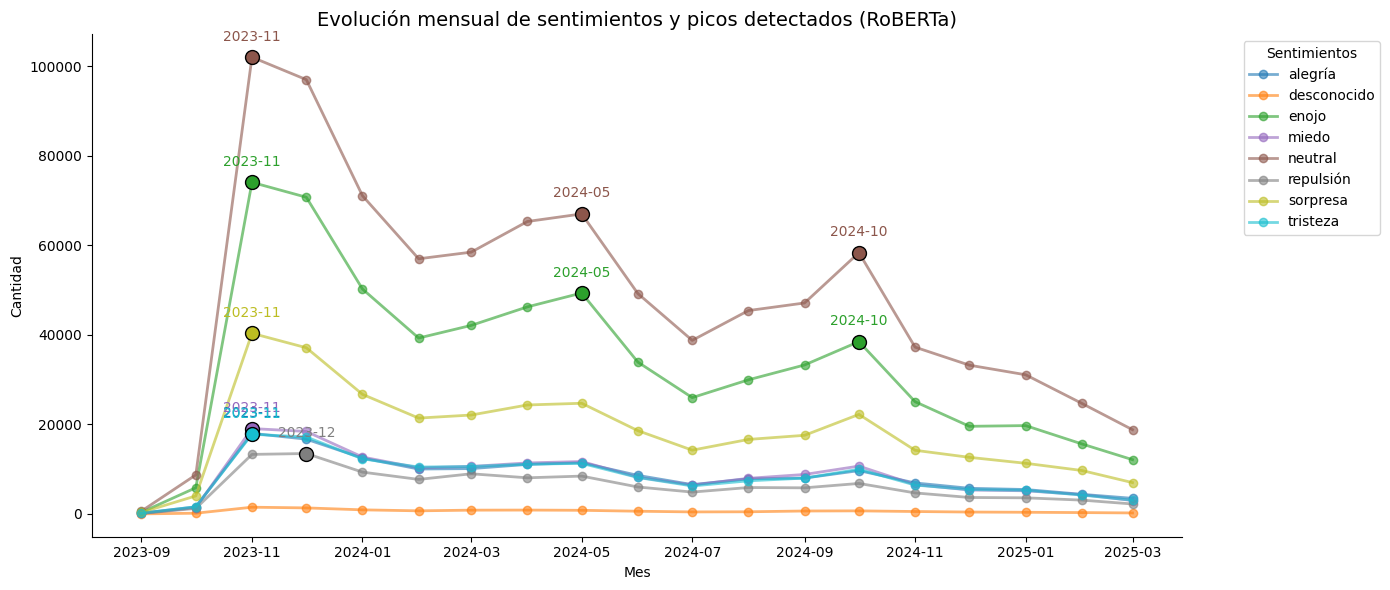

In [199]:
plot_monthly_emotions_with_peaks(monthly_counts_distilbert, peaks_distilbert_multiple, "DistilBERT", title="Evolución mensual de sentimientos y picos detectados (DistilBERT)", prominence=3000)
plot_monthly_emotions_with_peaks(monthly_counts_t5, peaks_t5_multiple, "T5", title="Evolución mensual de sentimientos y picos detectados (T5)", prominence=3000)
plot_monthly_emotions_with_peaks(monthly_counts_roberta, peaks_roberta_multiple, "RoBERTa", title="Evolución mensual de sentimientos y picos detectados (RoBERTa)", prominence=3000)